In [1]:
# %load_ext jupyternotify

In [305]:
# TODO: Fine looking logging while training
# TODO: Logging

### Dataset 

We will train out face recognition network on part of the [CelebA dataset](https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html). We'll use a version of it that has all the images in it aligned. You can download the dataset using the links: 
- (whole celebA dataset) [dataset with 10177 classes](https://drive.google.com/file/d/1R-J71aJ50ahF-PkmaytLDyvbAiCccQdl/view?usp=sharing)
- [dataset with 1000 classes](https://drive.google.com/file/d/1JT9CMGjIbO7LtUuh8IYRc2OYrY0lGy5r/view?usp=sharing) 

**Important**: images in both datasets are aligned, but not cropped. To crop images, there're files with bboxes coordinates for each image in both datasets

In [1]:
import os
# !gdown --id 1JT9CMGjIbO7LtUuh8IYRc2OYrY0lGy5r&export=download&confirm=t&uuid=e1a45a87-2fcc-421a-9430-5f3dc28d85ce
# if "celebA_train_1k" not in os.listdir():
#   ! unzip celebA_train_1k.zip;

In [2]:
# !pip install albumentations opencv-python timm --upgrade

In [3]:
# # this link won't work for you, if you want to generate working link, 
# # visit https://askubuntu.com/questions/1188381/how-to-get-link-of-file-to-download-with-wget
# # or download the data and place it to folder manually
# # ! wget "https://s404man.storage.yandex.net/rdisk/e0e5e83a8ed50a2dfedfc6bbe1081de4949c81c87d5410c45c2cedb578851f6a/618475fd/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg==?uid=316082386&filename=celebA_train_500.zip&disposition=attachment&hash=&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2&etag=1b0518cba143d479efa9e581d57ead35&rtoken=Ny3K3Z2QBMXq&force_default=yes&ycrid=na-9388316a3a9a2e64a8e248d7729518fe-downloader8f&ts=5cfff715bb940&s=ec587c110763937cfa598cc4f80ae49bcf87d3f82f3ad4c67cc053b2961d3a3b&pb=U2FsdGVkX1_M1VrRqOVGHQ-RDMSpA0_18Qqau6zdD_w8F5__FE9yGJWvrQlF_6i82qf1CSgs4iy4r74kLxZEQ9_ykd_KwAh7b5R393KQquE" -O celebA.zip
# ! unzip celebA_train_1k.zip;

Let's look at the data first:

- celebA_imgs — folder with aligned images 
- celebA_anno.txt — file with annotations: which person each image corresponds to
- celebA_train_split.txt — file with train/val/test info

In [4]:
# # For debugging
# os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [48]:
import os
import cv2
import numpy as np
from PIL import Image

from skimage import io, transform

import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import torchvision
import torch.nn.functional as F 
import torch.nn as nn

import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score
import copy

from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)

from contextlib import contextmanager

@contextmanager
def notebook_plot():
    %matplotlib notebook
    yield
    %matplotlib inline
    
%matplotlib inline

In [49]:
IMAGE_FOLDER = "celebA_train_1k/celebA_imgs"

In [50]:
target_df = pd.read_csv("celebA_train_1k/celebA_anno_1k.txt", sep=" ", names=["image_id","target"])
print("Number of classes:" , target_df.target.nunique())
target_df.shape

Number of classes: 1000


(23948, 2)

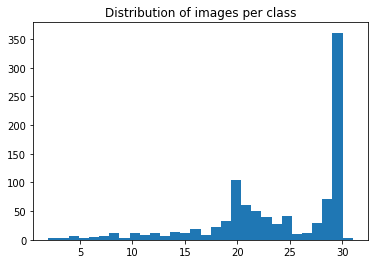

93     31
113    31
147    31
0      30
1      30
       ..
899     3
289     2
639     2
645     2
567     2
Name: target, Length: 1000, dtype: int64


In [51]:
plt.hist(target_df.target.value_counts(), 
         bins=np.unique(target_df.target.value_counts().values).size
         )
plt.title("Distribution of images per class")
plt.show()
print(target_df.target.value_counts())

In [52]:
n_enough_images = 5
classes_with_enough_images = target_df.target.value_counts().loc[lambda x: x >= n_enough_images].index
target_df = target_df.loc[target_df['target'].isin(classes_with_enough_images)]

target_df_train, target_df_val = train_test_split(target_df, test_size=0.15, stratify=target_df.target)
target_df_train, target_df_test = train_test_split(target_df_train, test_size=target_df_val.shape[0], stratify=target_df_train.target)

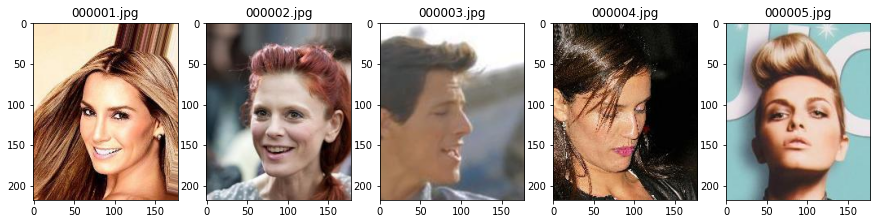

In [53]:
def show_imgs(images_names):
    imgs = []
    for img in images_names:
      img = Image.open(os.path.join('celebA_train_1k/celebA_imgs/', img))
      imgs.append(np.array(img))

    f, axes= plt.subplots(1, len(imgs), figsize=(3*len(imgs),5))
    for i, axis in enumerate(axes):
        axes[i].imshow(imgs[i], cmap='gray')
        axes[i].set_title(images_names[i])
    plt.show()

images_names = os.listdir('./celebA_train_1k/celebA_imgs/')[:5]
show_imgs(images_names)


In [54]:
from collections import defaultdict
import numpy as np
import albumentations as A
import os

In [55]:
def augmentDf(targets_df,  n_augm=0, even_mode=False):
    """
    targets_df: pd.DataFrame with cols=['image_id', 'target']
    even_mode: 
        False - to just add new img_paths
        True - to even the number of images per class. If "even" is chosen n_augm is omitted
    """
    if (n_augm > 0) or (even_mode == True):
        assert isinstance(
            even_mode, bool), "even_mode argument is not bool type "
        total_aug_img_names = []
        max_imgs_per_class = targets_df.target.value_counts().max()
        for class_val in np.unique(targets_df['target'].values):
            class_image_names = targets_df[targets_df['target']
                                           == class_val]['image_id'].values
            if even_mode:
                class_images_count = targets_df[targets_df.target == class_val].target.count(
                )
                n_augm_class = n_augm + max_imgs_per_class - class_images_count
            else:
                n_augm_class = n_augm
            aug_image_names = [[class_image_names[i], class_val] for i in np.random.choice(len(class_image_names),
                                                                                           n_augm_class,
                                                                                           replace=True
                                                                                           )
                               ]
            total_aug_img_names.extend(aug_image_names)

        targets_df = targets_df.append(pd.DataFrame(
            total_aug_img_names, columns=targets_df.columns), ignore_index=True)
        return targets_df
    else:
        return targets_df

Let's build a Datasets and network using this images:

In [56]:
class celebADataset_mine(Dataset):

    def __init__(self, dataset_type, targets_df, transform,
                 augm_even_mode=False, create_n_duplicates=0, aug=None,
                 classes_to_use=None,
                 is_wild_dataset=False
                ):
        self.transforms = transform
        self.aug = aug
        self.is_wild_dataset = is_wild_dataset
        if self.is_wild_dataset:
            # in the wild pictures dataset
            # I have all images in train folder
            self.image_folder = 'celebA_full_big_wild/images/train/'
        else:
            # 1k dataset
            self.image_folder = 'celebA_train_1k/celebA_imgs/'
        if self.is_wild_dataset:
            self.df_bbox = pd.read_csv(
                "celebA_train_1k/clist_bbox_celeba_1k.txt", " ").sort_index()
        df_copy = copy.deepcopy(targets_df)
        # Filtering only n=classes_to_use classes that have max number of photos
        if classes_to_use is not None:
            df_copy = df_copy.loc[df_copy.target.isin(classes_to_use)]

        # augmenting dataframe with duplicates of img_names
        if (augm_even_mode != False) or (create_n_duplicates > 0):
            df_copy = augmentDf(
                targets_df=df_copy, n_augm=create_n_duplicates, even_mode=augm_even_mode)
        
        # This part causes a trouble if datasets have different number of classes
        # Ultimately it skewes numbers of classes if some are missing imputing the missing numbers
        self.targets = np.unique(df_copy.target.values, return_inverse=True)[1]
        # self.targets = df_copy.target.values
        
        self.img_paths = np.array(list(map(lambda x: os.path.join(self.image_folder, x),
                                           df_copy['image_id'].values)))

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.img_paths[idx]
        sample = io.imread(img_name)
        target = self.targets[idx]
        if self.aug is not None:
            sample = self.aug(image=sample)['image']

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample, target

In [57]:
def get_3_dataloaders(batch_size, n_classes_to_use=1000, 
                      resize_size=None, crop_size=None, stats_for_norm = None,
                      even_augm_train=False, n_duplicates_train=0, common_p_aug=0,
                      is_wild_dataset=False
                     ):
    # Get n_classes_to_use number of classes with most pictures
    if n_classes_to_use != 1000:
        classes_to_use = target_df.target.value_counts().index[:n_classes_to_use].tolist()
    else:
        classes_to_use = None
    
    # Transformations applied to every dataset
    transforms_list = [
        transforms.ToPILImage(),
    ]
    if crop_size is not None:
        transforms_list.append(transforms.Pad((0,0,0,40)))
        transforms_list.append(transforms.CenterCrop(crop_size))
    if resize_size is not None:
        transforms_list.append(transforms.Resize(resize_size, transforms.InterpolationMode.LANCZOS))
    transforms_list.append(transforms.ToTensor())
    if stats_for_norm is not None:
        transforms_list.append(transforms.Normalize(*stats_for_norm))
    common_transforms = transforms.Compose(transforms_list)
    
    # Random augmentations applied to train dataset
    common_p = common_p_aug
    augment_transform = A.Compose([
        A.HorizontalFlip(p=common_p),
        A.RGBShift(p=common_p),
        A.GaussianBlur(blur_limit=(3, 5), sigma_limit=0, always_apply=False, p=common_p),
        A.CLAHE(clip_limit=0.2, tile_grid_size=(4,4), always_apply=False, p=common_p),
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=common_p),
        A.Equalize(mode="pil", p=common_p),
        A.GaussNoise(var_limit=(1.0, 5.0), mean=0, per_channel=True, always_apply=False, p=common_p),
#         A.MotionBlur(blur_limit=(3,4), p=common_p),
        A.PixelDropout(dropout_prob=0.01, per_channel=False, drop_value=0, mask_drop_value=None, always_apply=False, p=common_p),
        # A.ToSepia(always_apply=False, p=common_p_aug/4),
        # A.RandomShadow(shadow_roi=(0, 0, 1, 1), num_shadows_upper=1, shadow_dimension=4, p=common_p_aug),
        # A.Posterize(num_bits=4, always_apply=False, p=common_p),
        # A.Sharpen(alpha=(0.2, 0.5), lightness=(0.5, 1.0), always_apply=False, p=common_p),
        # A.ToGray(p=0.01),
        A.CoarseDropout(max_holes=30, max_height=50, max_width=24, 
                        min_holes=10, min_height=10, min_width=10, 
                        always_apply=False, p=common_p*1.5)
    ])

    train_data = celebADataset_mine('train', target_df_train, common_transforms, 
                                    augm_even_mode=even_augm_train, create_n_duplicates=n_duplicates_train, 
                                    aug=augment_transform,
                                    classes_to_use=classes_to_use,
                                    is_wild_dataset=is_wild_dataset
                                    )
    val_data = celebADataset_mine('val', target_df_val, common_transforms,
                                  classes_to_use=classes_to_use,
                                  is_wild_dataset=is_wild_dataset
                                  )
    test_data = celebADataset_mine('test', target_df_test, common_transforms,
                                   classes_to_use=classes_to_use,
                                   is_wild_dataset=is_wild_dataset
                                   )
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

In [58]:
BATCH_SIZE = 20
N_CLASSES_TO_USE = 50

CROP_SIZE = (90, 80)
RESIZE_SIZE = (112, 112)

EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 0
COMMON_P_AUG = 0.6

train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG,
    is_wild_dataset=False
)

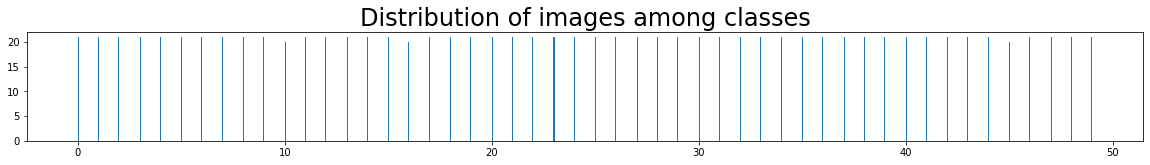

Length of train dataset 1047


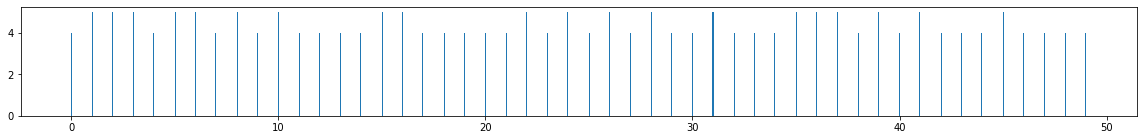

Length of val dataset 220


In [59]:
plt.figure(figsize=(20,2))
plt.title("Distribution of images among classes", fontsize=24)
plt.hist(train_loader_mine.dataset.targets, bins = 1000);
plt.title("Distribution of images among classes", fontsize=24)
plt.show()

print("Length of train dataset",len(train_loader_mine.dataset))

plt.figure(figsize=(20,2))
plt.hist(val_loader_mine.dataset.targets, bins = 1000);
plt.show()
print("Length of val dataset", len(val_loader_mine.dataset))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

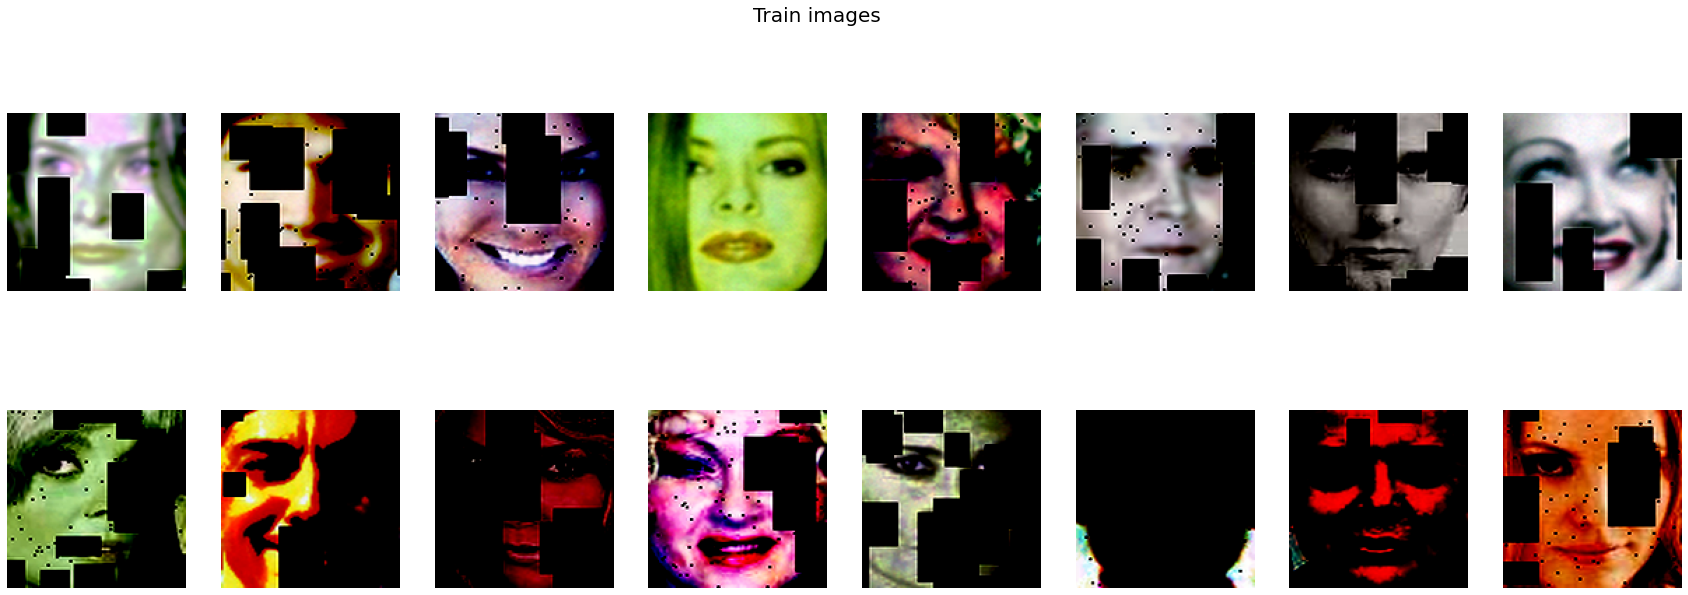

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


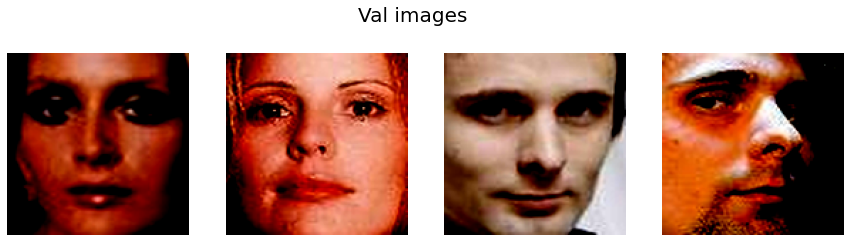

In [63]:
f, ax = plt.subplots(2,8)
f.set_size_inches(30,10)
plot_img = next(iter(train_loader_mine))
for i in range(ax.size):
    current_ax = np.ravel(ax)[i] 
    current_ax.imshow(plot_img[0][i].permute(1,2,0))
    current_ax.axis('off')
f.suptitle("Train images",fontsize=20)
plt.show()

f, ax = plt.subplots(1,4)
f.set_size_inches(15,4)
plot_img = next(iter(val_loader_mine))
for i in range(ax.size):
    current_ax = np.ravel(ax)[i] 
    current_ax.imshow(plot_img[0][i].permute(1,2,0))
    current_ax.axis('off')
f.suptitle("Val images", fontsize=20)
plt.show()

In [61]:
from tqdm.autonotebook import tqdm, trange
import time


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def plot_training_graphs(axes, x_plot, losses, metrics, lr_history):
    """
    
    """
    assert len(x_plot) >= 1, "Length of x_plot < 1"
    ax1, ax2, ax3 = axes
    if len(x_plot) == 1:
        # fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 9))
        # [axis.set_xlim(1, n_max_epochs) for axis in (ax1,ax2,ax3)]
        # ax4.remove()
        # Train and Val loss
        ax1.plot(losses['train'], color='orange', label='train')
        ax1.plot(losses['val'], color='dodgerblue', label='val')
        ax1.set_title(
            f"Loss (best train={round(np.min(losses['train']),6)}, best val={round(np.min(losses['val']),6)})")
        ax1.legend(prop={"size": 12})
        ax1.grid()
        ax1.set_yscale('log')
        # Train and Val metric
        ax2.plot(metrics['train'], color='orange', label='train')
        ax2.plot(metrics['val'], color='dodgerblue', label='val')
        ax2.set_title(
            f"Accuracy (best train={round(np.max(metrics['train']),6)}, best val={round(np.max(metrics['val']),6)})")
        ax2.legend(prop={"size": 12})
        ax2.grid()
        ax2.set_ylim(0,1.1) # Metric - accuracy
        # Learning Rate
        ax3.plot(lr_history, color='black')
        ax3.set_title('Learning rate during training')
        ax3.grid()
        ax3.set_yscale('log')
    else:
        ax1.set_ylim(np.min(losses['val']+losses['train'])*0.8, np.max(losses['val']+losses['train'])*1.1)
        ax3.set_ylim(np.min(lr_history)*0.8, np.max(lr_history)*1.2)
        ax1.lines[0].set_data(x_plot, losses['train'])
        ax1.lines[1].set_data(x_plot, losses['val'])
        ax2.lines[0].set_data(x_plot, metrics['train'])
        ax2.lines[1].set_data(x_plot, metrics['val'])
        ax3.lines[0].set_data(x_plot, lr_history)


def train(mode, model, optimizer, loss_fn, n_epochs, train_loader, valid_loader, scheduler=None):
    assert mode in ["arc", "ce"], "mode should be 'arc'-ArcFace or 'ce'-CrossEntropy"
    since = time.time()
    best_model_wts = None
    best_acc = 0.0
    losses = {'train': [], "val": []}
    metrics = {'train': [], "val": []}
    lr_history = []
    x_plot = []
    
    with notebook_plot():
        fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2, 2, figsize=(12, 9))
        ax4.remove()
        [axis.set_xlim(1, n_epochs) for axis in (ax1,ax2,ax3)]
        fig.tight_layout()
        fig.subplots_adjust(hspace=0.2, wspace=0.1, top=0.95, left=0.07)
        
        pbar = trange(n_epochs, desc="Epoch:")
        for epoch in pbar:
            #####################
            # Training
            #####################
            model.train()
            train_losses_epoch = []
            train_metrics_epoch = []
            for x_batch, y_real in tqdm(train_loader, leave=True, desc=f"{epoch} iter:"):
                optimizer.zero_grad()
                if mode=='ce':
                    y_model = model(x_batch.to(device))
                elif mode=='arc':
                    y_model = model(x_batch.to(device), y_real.to(device))

                loss = loss_fn(y_model, y_real.to(device))
                loss.backward()
                optimizer.step()

                train_losses_epoch.append(loss.item())
                train_metrics_epoch.append(accuracy_score(y_real,
                                                          np.argmax(
                                                              y_model.detach().cpu().numpy(), 1)
                                                          )
                                           )
            epoch_loss_train = np.mean(train_losses_epoch)
            epoch_acc_train = np.mean(train_metrics_epoch)
            losses['train'].append(epoch_loss_train)
            metrics['train'].append(epoch_acc_train)
            #####################
            # Validation
            #####################
            val_losses_epoch = []
            val_metrics_epoch = []
            model.eval()
            with torch.no_grad():
                for x_batch, y_real in tqdm(valid_loader, leave=False, desc=f"{epoch} iter:"):
                    if mode=='ce':
                        y_model = model(x_batch.to(device))
                    elif mode=='arc':
                        y_model = model(x_batch.to(device), y_real.to(device))
                    loss = loss_fn(y_model, y_real.to(device))
                    val_losses_epoch.append(loss.item())
                    val_metrics_epoch.append(accuracy_score(y_real,
                                                            np.argmax(
                                                                y_model.detach().cpu().numpy(), 1)
                                                            ))
            epoch_loss_val = np.mean(val_losses_epoch)
            epoch_acc_val = np.mean(val_metrics_epoch)
            losses['val'].append(epoch_loss_val)
            metrics['val'].append(epoch_acc_val)
            #####################
            # Stepping with scheduler and saving lr
            if scheduler is not None:
                scheduler.step()
            lr_history.append(get_lr(optimizer))
            #####################
            # Training Info
            pbar.set_description('ValLoss: {:.4f} ValAcc: {:.4f}'.format(
                epoch_loss_val, epoch_acc_val
            ))
            print(f"Epoch {epoch+1}/{n_epochs}\nTrain Loss = {losses['train'][-1]}\nValidation Loss = {losses['val'][-1]}")
            #####################
            # Save best model
            if epoch_acc_val > best_acc:
                best_acc = epoch_acc_val
                best_model_wts = copy.deepcopy(model.state_dict())
            #####################
            # Plotting training graphs
            x_plot.append(epoch+1)
            plot_training_graphs((ax1,ax2,ax3), x_plot, losses, metrics, lr_history)
            fig.canvas.draw()

        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: {:4f}'.format(best_acc))

        # Returning best model
        if best_model_wts is not None:
            model.load_state_dict(best_model_wts)
        return model


def inference_model(model_to_test, loader, mode):
    model_to_test.eval()
    test_preds = []
    with torch.no_grad():
        for test_im, test_lab in loader:
            if mode == 'arc':
                preds_iter = model_to_test(test_im.to(device), test_lab.to(device))
            if mode == 'ce':
                preds_iter = model_to_test(test_im.to(device))
        test_preds.append(preds_iter.argmax(dim=1).cpu().numpy())
    test_score = accuracy_score(loader.dataset.targets, np.concatenate(test_preds))
    return test_score

# Train History

### Checking optimizers

Epoch 35/35
Train Loss = 0.006055410105126122
Validation Loss = 1.276084065437317
Learning rate 0.0001


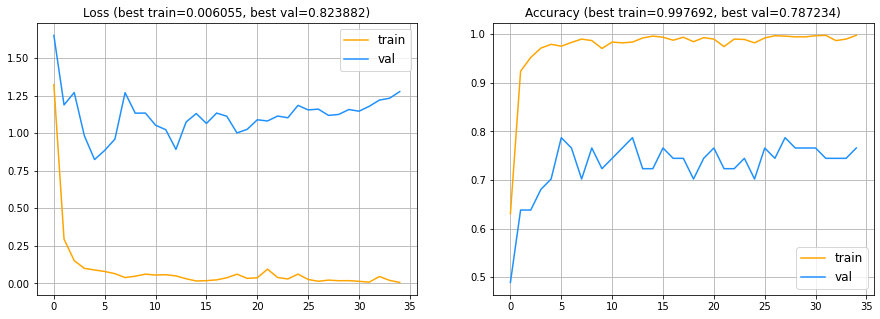

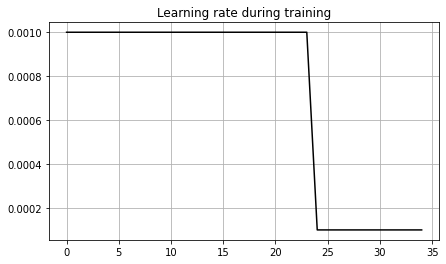

Training complete in 3m 58s
Best val Acc: 0.787234
Val accuracy 0.7659574468085106
Test accuracy 0.8913043478260869


In [59]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.1
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)


# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.011926642178038422
Validation Loss = 0.9062246084213257
Learning rate 0.0001


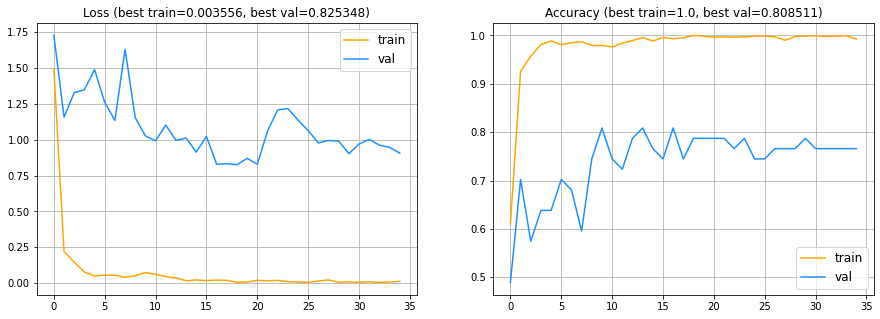

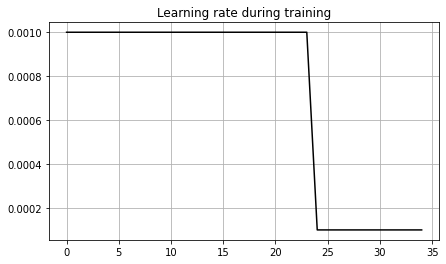

Training complete in 3m 47s
Best val Acc: 0.808511
Val accuracy 0.7659574468085106
Test accuracy 0.8478260869565217


In [60]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.1
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
optim = torch.optim.AdamW(model_ce.parameters(), )
optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)


# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.005644142526972036
Validation Loss = 0.6851521730422974
Learning rate 0.001


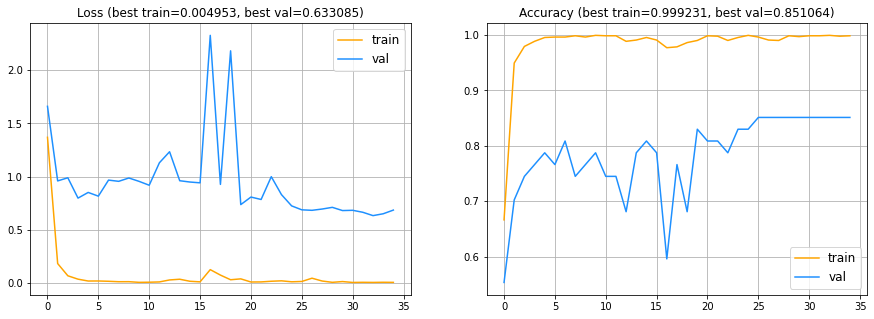

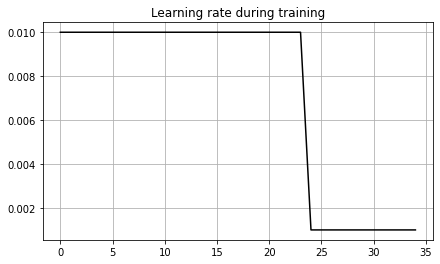

Training complete in 3m 31s
Best val Acc: 0.851064
Val accuracy 0.851063829787234
Test accuracy 0.8478260869565217


In [61]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.1
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
optim = torch.optim.Adagrad(model_ce.parameters(),)


# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.23949347207179436
Validation Loss = 1.5779608488082886
Learning rate 0.001


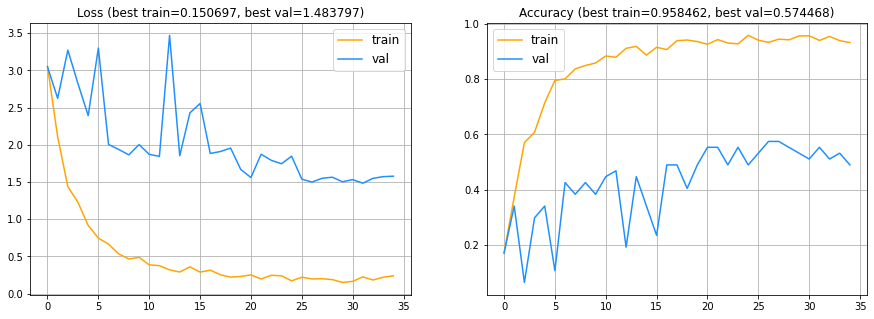

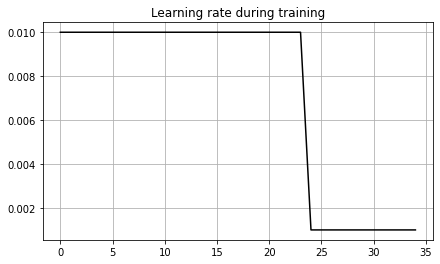

Training complete in 3m 28s
Best val Acc: 0.574468
Val accuracy 0.48936170212765956
Test accuracy 0.6304347826086957


In [62]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.1
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
optim = torch.optim.SGD(model_ce.parameters(), lr=1e-2)

# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.002049001110068415
Validation Loss = 0.6429053544998169
Learning rate 0.1


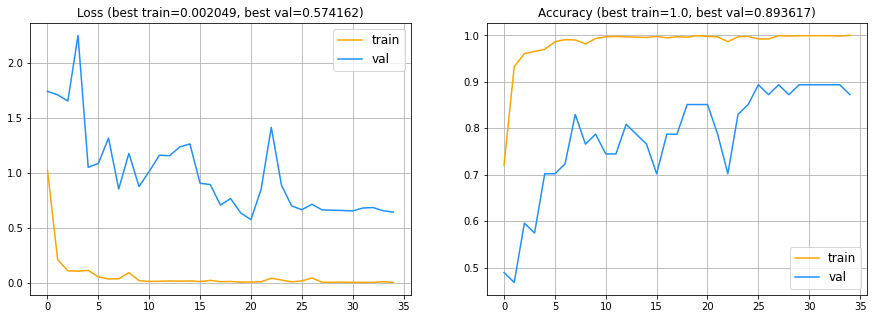

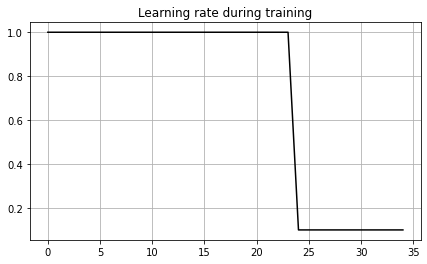

Training complete in 3m 30s
Best val Acc: 0.893617
Val accuracy 0.8723404255319149
Test accuracy 0.8695652173913043


In [63]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.1
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
# optim = torch.optim.SGD(model_ce.parameters(),)
optim = torch.optim.Adadelta(model_ce.parameters(),)



# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

### 10 Classes - High Coarse

Epoch 35/35
Train Loss = 0.08905066650074261
Validation Loss = 0.7060014605522156
Learning rate 0.1


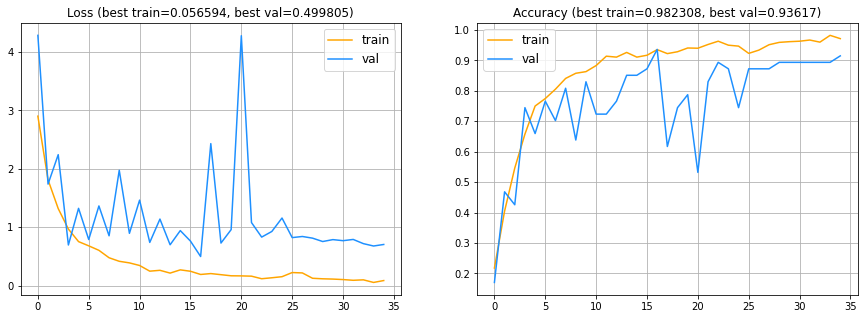

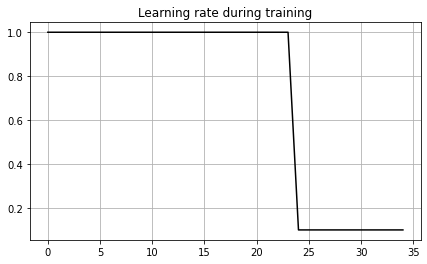

Training complete in 6m 9s
Best val Acc: 0.936170
Val accuracy 0.9148936170212766
Test accuracy 0.9130434782608695


In [249]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 100
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.5
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
# optim = torch.optim.SGD(model_ce.parameters(),)
optim = torch.optim.Adadelta(model_ce.parameters(), )



# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.008509713555104098
Validation Loss = 0.25729474425315857
Learning rate 0.5


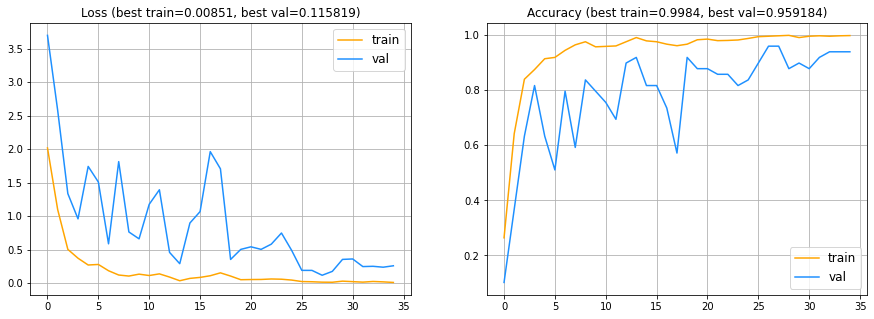

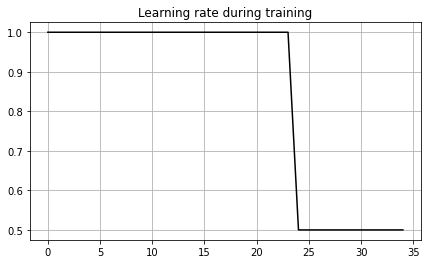

Training complete in 9m 32s
Best val Acc: 0.959184
Val accuracy 0.9387755102040817
Test accuracy 0.8636363636363636


In [20]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 50
N_CLASSES_TO_USE = 10
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.5
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
# model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
# optim = torch.optim.SGD(model_ce.parameters(),)
optim = torch.optim.Adadelta(model_ce.parameters(), )



# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.5)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Epoch 35/35
Train Loss = 0.010393128761610238
Validation Loss = 0.7541309624910355
Learning rate 0.5


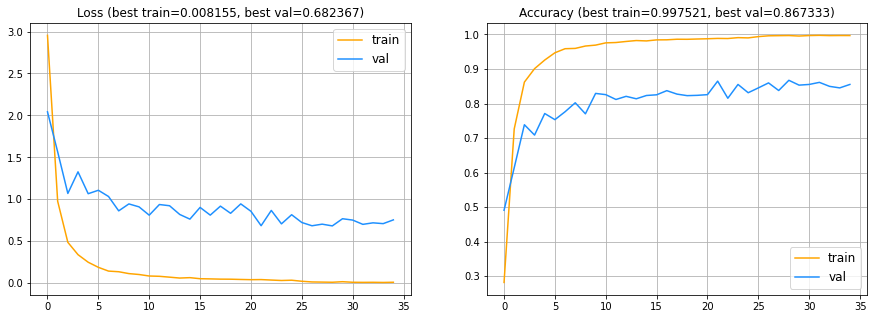

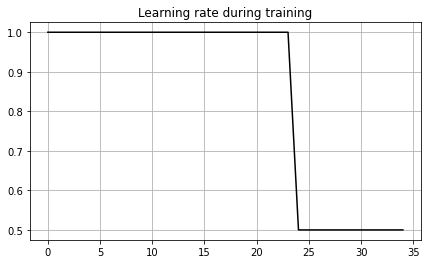

Training complete in 95m 8s
Best val Acc: 0.867333
Val accuracy 0.8568376068376068
Test accuracy 0.8633257403189066


In [21]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 50
N_CLASSES_TO_USE = 100
CROP_SIZE = (90, 80)
RESIZE_SIZE = (128, 128)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 100
COMMON_P_AUG = 0.5
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
# model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 35
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
# optim = torch.optim.SGD(model_ce.parameters(),)
optim = torch.optim.Adadelta(model_ce.parameters(), )



# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.5)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

In [22]:
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

Val accuracy 0.8568376068376068
Test accuracy 0.8633257403189066


In [23]:
# torch.save(model_ce.state_dict(), "saved_models_RE/effnetv2s_100classes_128.pth")

## All classes

### 224*224 AdaDelta 

Epoch 10/10
Train Loss = 0.0014239157576000781
Validation Loss = 1.007239663393961
Learning rate 1.0


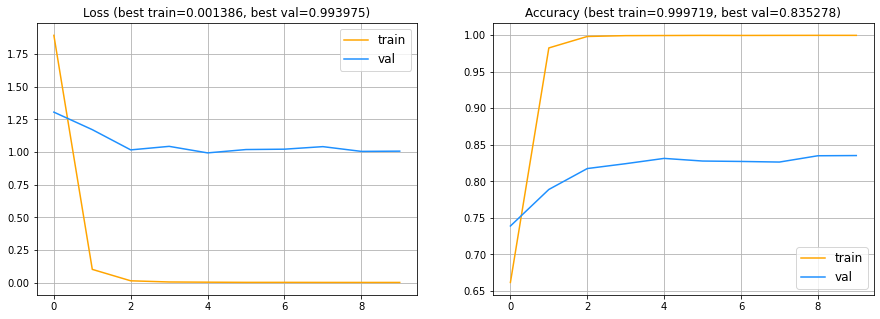

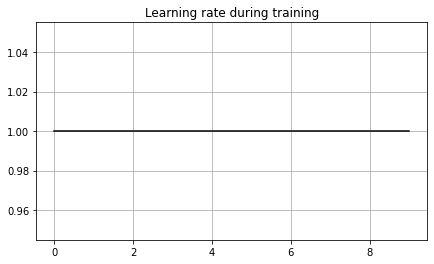

Training complete in 452m 16s
Best val Acc: 0.835278
Val accuracy 0.8354253835425384
Test accuracy 0.8382147838214784


In [64]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 20
N_CLASSES_TO_USE = 1000
CROP_SIZE = (90, 80)
RESIZE_SIZE = (224, 224)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 200
COMMON_P_AUG = 0.3
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 10
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
#     label_smoothing=0.1, 
)
# optim = torch.optim.AdamW(model_ce.parameters(), )
# optim = torch.optim.Adam(model_ce.parameters(), )
# optim = torch.optim.Adagrad(model_ce.parameters(),)
# optim = torch.optim.SGD(model_ce.parameters(),)
optim = torch.optim.Adadelta(model_ce.parameters(),)



# optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-5)
# optim = torch.optim.AdamW([
#     {'params': list(model_ce.parameters())[:-2]},
#     {'params': list(model_ce.parameters())[-2:], 'lr': LR*10}], 
#     lr=LR, 
#     weight_decay=1e-6)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[25], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
print("Val accuracy", inference_model(model_ce, val_loader_mine, 'ce'))
print("Test accuracy", inference_model(model_ce, test_loader_mine, 'ce'))

In [65]:
# torch.save(model_ce.state_dict(), "saved_models/semnasnet_almost1000classes.pth")

# Cosine similarity

**Cosine similarity calculation**: drop a last layer of trained network. Get embeddings for some images from train set and for images from test set. Calculate cosine similarities between embeddings corresponding to the pictures of the same person and different people. Is the difference big in any of cases?

In [65]:
from sklearn.metrics.pairwise import cosine_similarity
import copy

In [116]:
BATCH_SIZE = 20
N_CLASSES_TO_USE = 1000
CROP_SIZE = (90, 80)
RESIZE_SIZE = (224, 224)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 0
COMMON_P_AUG = 0
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
    stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)
train_data = train_loader_mine.dataset
test_data = test_loader_mine.dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


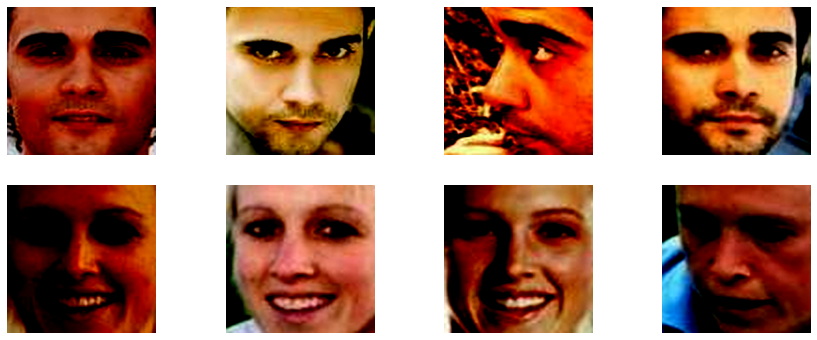

In [155]:
person_idxs1 = np.where(train_data.targets==np.random.choice(N_CLASSES_TO_USE))[0]
person_idxs2 = np.where(train_data.targets==np.random.choice(N_CLASSES_TO_USE))[0]

n_cols_plot = min(len(person_idxs1), len(person_idxs2), 4)

person_tensor1 = torch.stack([train_data[idx][0] for idx in person_idxs1])[:n_cols_plot]
person_tensor2 = torch.stack([train_data[idx][0] for idx in person_idxs2])[:n_cols_plot]

plot_tensors = torch.cat([person_tensor1, person_tensor2])

f, ax = plt.subplots(2,n_cols_plot)
f.set_size_inches(15,6)
for i in range(ax.size):
    current_ax = np.ravel(ax)[i] 
    current_ax.imshow(plot_tensors[i].permute(1,2,0))
    current_ax.axis('off')
plt.show()

In [158]:
emb_model = timm.create_model('semnasnet_075', pretrained=True, num_classes=N_CLASSES_TO_USE)
# emb_model.classifier[1] = nn.Linear(emb_model.classifier[1].in_features, N_CLASSES_TO_USE)
# emb_model.load_state_dict(torch.load("saved_models/Eff_net_500classes.pth"))
emb_model.load_state_dict(torch.load("saved_models_RE/semnasnet_almost1000classes5thr.pth"))

# Removing classification layer
emb_model = nn.Sequential(*list(emb_model.children())[:-1])
emb_model.to(device);
emb_model.eval()

with torch.no_grad():
    emb_vector1 = emb_model((person_tensor1).to(device)).cpu().flatten(1)
    emb_vector2 = emb_model((person_tensor2).to(device)).cpu().flatten(1)

In [157]:
print("Distribution of similarities between pictures of same person\n{}".format(cosine_similarity(emb_vector1).round(2)))
print("Distribution of similarities between pictures of different people\n{}".format(cosine_similarity(emb_vector1, emb_vector2).round(2)))

Distribution of similarities between pictures of same person
[[1.   0.56 0.37 0.65]
 [0.56 1.   0.35 0.63]
 [0.37 0.35 1.   0.36]
 [0.65 0.63 0.36 1.  ]]
Distribution of similarities between pictures of different people
[[0.19 0.18 0.15 0.19]
 [0.25 0.21 0.23 0.24]
 [0.18 0.21 0.2  0.21]
 [0.19 0.16 0.13 0.16]]


In [159]:
print("Distribution of similarities between pictures of same person\n{}".format(cosine_similarity(emb_vector1).round(2)))
print("Distribution of similarities between pictures of different people\n{}".format(cosine_similarity(emb_vector1, emb_vector2).round(2)))

Distribution of similarities between pictures of same person
[[1.   0.74 0.59 0.81]
 [0.74 1.   0.62 0.78]
 [0.59 0.62 1.   0.59]
 [0.81 0.78 0.59 1.  ]]
Distribution of similarities between pictures of different people
[[0.35 0.38 0.36 0.35]
 [0.42 0.44 0.43 0.44]
 [0.39 0.45 0.49 0.45]
 [0.35 0.38 0.34 0.35]]


**Cosine similarity distribution**: calculate all the cosine similarities between images in test dataset and train dataset of the same person. This means if you have image of person #106 in test dataset, calculate all similarities between this person's embeddings from test dataset and this person's embeddings from train dataset. 

Then also do that for pairs of different people. This means if you have image of person #106 in test dataset, calculate similarities between this person's embeddings from test dataset and other people embeddings from train dataset. 

This calculation may take a long time and memory since it's a lot of pairs. You can cut the number of pairs which you calculate distances between up to 5k, as an example.

In [160]:
PERSON_CLASS = np.random.choice(N_CLASSES_TO_USE)
person_idxs_tr = np.where(train_data.targets==PERSON_CLASS)[0]
person_idxs_ts = np.where(test_data.targets==PERSON_CLASS)[0]

person_x_train = torch.stack([train_data[idx][0] for idx in person_idxs_tr])
person_x_test = torch.stack([test_data[idx][0] for idx in person_idxs_ts])

In [161]:
with torch.no_grad():
    person_x_train_emb = emb_model((person_x_train).to(device)).cpu().flatten(1)
    person_x_test_emb = emb_model((person_x_test).to(device)).cpu().flatten(1)

cos_sims_xx = cosine_similarity(person_x_train_emb, person_x_test_emb).round(2)
cos_sims_xx

array([[0.77, 0.69, 0.57, 0.74, 0.8 ],
       [0.78, 0.82, 0.53, 0.82, 0.82],
       [0.46, 0.45, 0.64, 0.44, 0.45],
       [0.65, 0.83, 0.6 , 0.81, 0.8 ],
       [0.54, 0.56, 0.74, 0.55, 0.56],
       [0.83, 0.8 , 0.54, 0.87, 0.89],
       [0.75, 0.77, 0.53, 0.78, 0.79],
       [0.75, 0.85, 0.57, 0.84, 0.83],
       [0.68, 0.75, 0.65, 0.73, 0.74],
       [0.65, 0.72, 0.64, 0.69, 0.71],
       [0.65, 0.71, 0.66, 0.74, 0.72],
       [0.68, 0.74, 0.64, 0.73, 0.72],
       [0.74, 0.73, 0.61, 0.81, 0.79],
       [0.71, 0.79, 0.5 , 0.8 , 0.78],
       [0.7 , 0.84, 0.63, 0.84, 0.83],
       [0.59, 0.75, 0.61, 0.69, 0.7 ],
       [0.78, 0.85, 0.59, 0.86, 0.85],
       [0.71, 0.82, 0.67, 0.84, 0.83],
       [0.74, 0.7 , 0.57, 0.77, 0.8 ],
       [0.67, 0.73, 0.6 , 0.76, 0.8 ],
       [0.81, 0.77, 0.55, 0.83, 0.86]], dtype=float32)

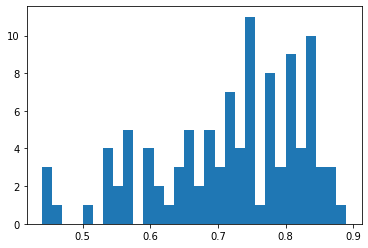

In [162]:
plt.hist(cos_sims_xx.ravel(), bins=30);

>Несколько людей - с самим собой

In [163]:
total_xx = np.empty(0)
classes_nums = np.intersect1d(np.unique(train_data.targets), np.unique(test_data.targets))

with torch.no_grad():
    for person_x_class in classes_nums: 
        person_idxs_tr = np.where(train_data.targets==person_x_class)[0]
        person_idxs_ts = np.where(test_data.targets==person_x_class)[0]

        person_x_train = torch.stack([train_data[idx][0] for idx in person_idxs_tr])
        person_x_test = torch.stack([test_data[idx][0] for idx in person_idxs_ts])

        person_x_train_emb = emb_model((person_x_train).to(device)).cpu().flatten(1)
        person_x_test_emb = emb_model((person_x_test).to(device)).cpu().flatten(1)

        cos_sims_xx = cosine_similarity(person_x_train_emb, person_x_test_emb).round(5)
        total_xx = np.append(total_xx, cos_sims_xx.flatten())

>Разные людие друг с другом

In [171]:
total_xy = np.empty(0)
classes_nums = np.intersect1d(np.unique(train_data.targets), np.unique(test_data.targets))

pairs_cnt = 0
max_pairs = 3000
with torch.no_grad():
    with tqdm(total = max_pairs) as pbar:
        for person_x_class in classes_nums:
            person_y_classes = classes_nums[classes_nums != person_x_class]
            for person_y_class in person_y_classes:
                if pairs_cnt > max_pairs: break
                person_idxs_x = np.where(train_data.targets==person_x_class)[0]
                person_idxs_y = np.where(test_data.targets==person_y_class)[0]

                person_x = torch.stack([train_data[idx][0] for idx in person_idxs_x])
                person_y = torch.stack([test_data[idx][0] for idx in person_idxs_y])

                person_x_emb = emb_model((person_x).to(device)).cpu().flatten(1)
                person_y_emb = emb_model((person_y).to(device)).cpu().flatten(1)

                cos_sims_xx = cosine_similarity(person_x_emb, person_y_emb).round(5)
                total_xy = np.append(total_xy, cos_sims_xx.flatten())

                pbar.update(1)
                pairs_cnt += 1
            classes_nums = classes_nums[classes_nums!=person_x_class]

  0%|          | 0/30 [00:00<?, ?it/s]

>Построим распределения

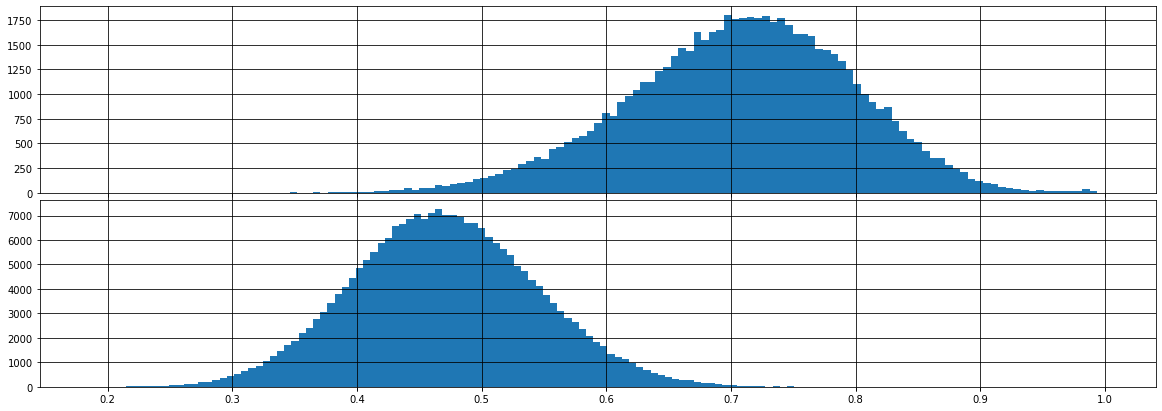

XX pairs mean: 0.7080225613356461
XY pairs mean: 0.4702523516041204


In [165]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)

ax3 = fig.add_subplot(111, zorder=-1)
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax3.get_shared_x_axes().join(ax3,ax1)
ax3.grid(axis="x", color='black')


fig.set_size_inches((20,7))
fig.subplots_adjust(hspace=0.04)

ax1.hist(total_xx, bins = 111)
ax1.grid(color='black')
ax2.hist(total_xy, bins = 111);
ax2.grid(color='black')

plt.show()
print("XX pairs mean: {}\nXY pairs mean: {}".format(total_xx.mean(), total_xy.mean()))

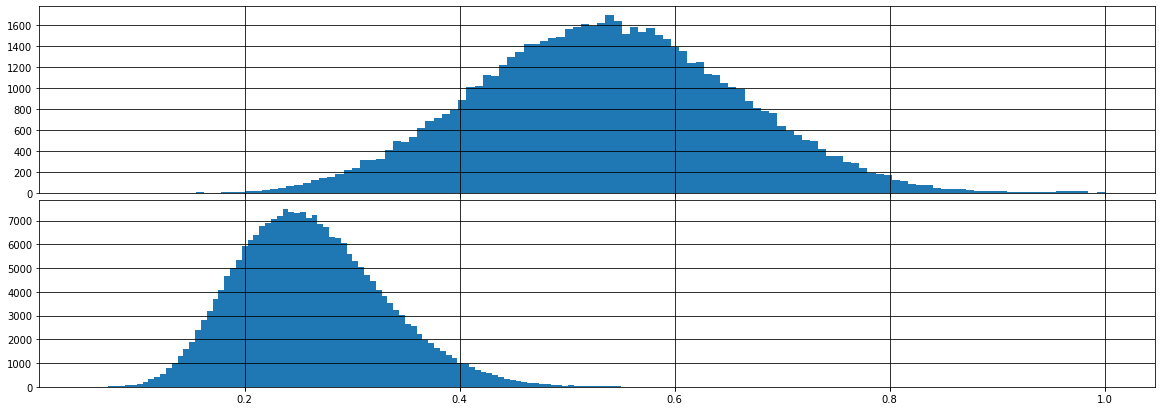

XX pairs mean: 0.5376026661279473
XY pairs mean: 0.26189239877060305


In [142]:
fig, (ax1,ax2) = plt.subplots(2,1,sharex=True)

ax3 = fig.add_subplot(111, zorder=-1)
for _, spine in ax3.spines.items():
    spine.set_visible(False)
ax3.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax3.get_shared_x_axes().join(ax3,ax1)
ax3.grid(axis="x", color='black')


fig.set_size_inches((20,7))
fig.subplots_adjust(hspace=0.04)

ax1.hist(total_xx, bins = 111)
ax1.grid(color='black')
ax2.hist(total_xy, bins = 111);
ax2.grid(color='black')

plt.show()
print("XX pairs mean: {}\nXY pairs mean: {}".format(total_xx.mean(), total_xy.mean()))

# Task 2 (20% points): Identificaton rate metric

When training the model above we used CE loss on val and test set as a measure of performance of our model. But this has a major disadvantage: we can't measure how godd a model would work on unseen faces (which are not present in training, val & test sets)

To address this we can calculate another metric for the model: **identification rate**. This is how it works:

We have two sets of faces: query and distractors. None of the faces from those sets are present in train, val or test sets.

1. calculate cosine similarities between all the faces corresponding to the same people from query dataset. This means if the person has 3 photos in query part: 01.jpg, 02.jpg, 03.jpg, then calculate 3 cosine similarities between every pair of embeddings corresponding to those photos. 
2. calculate cosine similarities between all the faces corresponding to the different people from query dataset. 
3. calculate cosine similarities between all the pairs of embeddings corresponding to query and distractors. This means calculate similarities between pairs (q, d), where q is the embedding that corresponds to a face from query, d — embedding that corresponds to a face from distractors. You'll get |query|*|distractors| similarities.
4. Sum numbers of similarities from 2 and 3 stages. This is a number of false pairs.
5. fix **FPR** (false positive rate). Let it be 0.01 in our case. FPR multiplied by a number of false pairs from the stage 4 is the number of false positives we would allow our model to make. Let's call this number N
6. Sort all the similarities of false pairs by descending order. Get the Nth element from the beginning — that's our **threshold similarity**.
7. Calculate how many positive similarities from stage 1 are equal or more that threshold. Divide this number by whole number of positive similarities from stage 1. This is TPR (true positive rate) — our metric.

This metric can also be expressed as TPR@FPR=0.01. FPR can vary. 

Datasets (query photos, query labels & distructors photos) you can download from here: https://disk.yandex.ru/d/C54mClLmQkag6Q

**Task**: implement the TPR@FPR metric. Calculate it for your model and test dataset on FPR=[0.5, 0.2, 0.1, 0.05].

There're some functions pre-defined and some tests given for better understanding. Please don't change the functions prototypes, so that you can use asserts for checking.

In [ ]:
# import os
# !gdown --id 1oCtHhyfs--dVECZ4OU9_frZRi_EUG7CR
# if "celebA_ir" not in os.listdir():
#   ! unzip celebA_ir.zip;

In [ ]:
import pandas as pd
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
with open('./celebA_ir/celebA_anno_query.txt', 'r') as f:
    query_lines = f.readlines()
query_lines = [x.strip().split() for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)


# list of distractor images
distractors_img_names = sorted(os.listdir('./celebA_ir/celebA_distractors'))

df_query = pd.read_csv("./celebA_ir/celebA_anno_query.txt",
                       sep=' ', names=("image_path", "target"))

In [ ]:
class qd_dataset(Dataset):
    def __init__(self, dataset_type, transform=None, distractors_img_names=None, query_targets_df=None):
        assert dataset_type in ('q', 'd'), "dataset_type should be in ['q','d']"
        self.dataset_type = dataset_type
        self.transforms = transform
        self.image_folder = "./celebA_ir/celebA_query" if self.dataset_type=='q'else "./celebA_ir/celebA_distractors"
        
        if dataset_type=='q':
            assert query_targets_df is not None, "Dataset type is 'q' however no query_targets_df is provided"
            self.query_targets_df = query_targets_df.copy()
            self.query_targets_df.image_path = self.query_targets_df.image_path.transform(lambda val: os.path.join("./celebA_ir/celebA_query", val))

        else:
            assert distractors_img_names is not None, "Dataset type is 'd' however no distractors_img_names is provided"
            self.distractors_img_paths = list(map(lambda val: os.path.join(self.image_folder,val), distractors_img_names))
      
    def __len__(self):
        if self.dataset_type == 'q':
            return len(self.query_targets_df)
        else:
            return len(self.distractors_img_paths)
    
    def __getitem__(self, idx):      
        if torch.is_tensor(idx):
            idx = idx.tolist()
        if self.dataset_type == 'q':
            img_path, target  = self.query_targets_df.iloc[idx].values
            image = io.imread(img_path)
            if self.transforms is not None:
                image = self.transforms(image)
            return image, target
        else:
            img_path = self.distractors_img_paths[idx]
            image = io.imread(img_path)
            if self.transforms is not None:
                image = self.transforms(image)
            return image

In [ ]:
def compute_embeddings(model,
                       #  images_names_list,
                       subset,
                       qd_batch_size=10
                       ):
    '''
    compute embeddings from the trained model for list of images.
    params:
      model: trained nn model that takes images and outputs embeddings
      # images_names_list: list of images paths to compute embeddings for
      subset: "q" - query folder, "d" - distractors folder
    output:
      list: list of model embeddings. Each embedding corresponds to images 
            names from images_list
    '''

    embs_list = []

    if subset == "q":
        # img_paths = list(map(lambda x: os.path.join("celebA_ir/celebA_query", x), images_names_list))
        dataset_embs = qd_dataset(
            'q', query_targets_df=df_query, transform=qd_transforms)
        dataloader_embs = torch.utils.data.DataLoader(
            dataset=dataset_embs, batch_size=qd_batch_size, shuffle=False)
    elif subset == "d":
        # img_paths = list(map(lambda x: os.path.join("celebA_ir/celebA_distractors", x), images_names_list))
        dataset_embs = qd_dataset(
            'd', distractors_img_names=distractors_img_names, transform=qd_transforms)
        dataloader_embs = torch.utils.data.DataLoader(
            dataset=dataset_embs, batch_size=qd_batch_size, shuffle=False)
    else:
        raise Exception("InvalidSubset")

    model.eval()
    with torch.no_grad():
        if subset == "q":
            for img, _ in tqdm(dataloader_embs):
                emb = model(img.to(device)).cpu().flatten(1).numpy()
                embs_list.append(emb)
        else:
            for img in tqdm(dataloader_embs):
                emb = model(img.to(device)).cpu().flatten(1).numpy()
                embs_list.append(emb)

    return np.concatenate(embs_list)

In [ ]:
resize_size = (224, 224)
qd_transforms_list = [
    transforms.ToTensor(),
    transforms.Resize(resize_size)
    ]
qd_transforms = transforms.Compose(qd_transforms_list)

# query_dataset = qd_dataset('q', query_targets_df=df_query, transform=qd_transforms)
# distractors_dataset = qd_dataset('d', distractors_img_names=distractors_img_names, transform=transforms.ToTensor())

# qd_batch_size = 256
# query_dataloader = torch.utils.data.DataLoader(dataset=query_dataset, batch_size=qd_batch_size, shuffle=False)
# distractors_dataloader = torch.utils.data.DataLoader(dataset=distractors_dataset, batch_size=qd_batch_size, shuffle=False)

In [ ]:
# CROSS ENTROPY
emb_model = torchvision.models.efficientnet_v2_s()
emb_model.classifier[1] = nn.Linear(emb_model.classifier[1].in_features, 500)
# emb_model.load_state_dict(torch.load("saved_models/Eff_net_500classes.pth"))
emb_model.load_state_dict(torch.load("trained_models/Eff_net_500classes.pth"))
# Removing classification layer
emb_model = nn.Sequential(*list(emb_model.children())[:-1])
emb_model.to(device);
emb_model.eval()

query_embeddings = compute_embeddings(emb_model, "q")
distractors_embeddings = compute_embeddings(emb_model, "d")

  0%|          | 0/720 [00:00<?, ?it/s]

  0%|          | 0/2340 [00:00<?, ?it/s]

In [ ]:
from copy import deepcopy

def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between positive pairs from query (stage 1)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding 
                      to the same people from query list
    '''
    sims_list = []
    for key, val in query_dict.items():
        if len(val) > 1:
            person_ids = list(map(query_img_names.index, val))
            person_embs = [query_embeddings[i] for i in person_ids]

            # only values higher diagonal
            cos_sim = cosine_similarity(person_embs)
            cos_sim = cos_sim[np.triu_indices_from(cos_sim, k=1)]

            sims_list.append(cos_sim)

    sims_list = np.concatenate(sims_list)
    return sims_list


def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
    compute cosine similarities between negative pairs from query (stage 2)
    params:
      query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in 
                  the dataset. Value: images corresponding to that class
      query_img_names: list of images names
      query_embeddings: list of embeddings corresponding to query_img_names
    output:
      list of floats: similarities between embeddings corresponding 
                      to different people from query list
    '''
    sims_list = []
    freeIdx = list(range(len(query_img_names)))
    query_embeddings_copy = np.array(deepcopy(query_embeddings))
    for key, val in query_dict.items():
        person_ids_x = list(map(query_img_names.index, val))
        for used_idx in person_ids_x:
            freeIdx.remove(used_idx)

        person_embs_x = query_embeddings_copy[person_ids_x]
        query_embeddings_y = query_embeddings_copy[freeIdx]

        if query_embeddings_y.size == 0:
            break

        cos_sim = cosine_similarity(person_embs_x, query_embeddings_y).ravel()

        sims_list.append(cos_sim)
    sims_list = np.concatenate(sims_list)

    return sims_list


def compute_cosine_query_distractors(query_embeddings, distractors_embeddings, n_chunks=10):
    '''
    compute cosine similarities between negative pairs from query and distractors
    (stage 3)
    params:
      query_embeddings: list of embeddings corresponding to query_img_names
      distractors_embeddings: list of embeddings corresponding to distractors_img_names
    output:
      list of floats: similarities between pairs of people (q, d), where q is 
                      embedding corresponding to photo from query, d —
                      embedding corresponding to photo from distractors
    '''
    sims_list = []
    chunk_size = int(len(query_embeddings) / n_chunks)
    if chunk_size > 100:
        for i in range(0, len(query_embeddings), chunk_size):
            cos_sim = cosine_similarity(
                query_embeddings[i:i+chunk_size], distractors_embeddings).ravel()
            sims_list.append((cos_sim))
        del cos_sim
        sims_list = np.concatenate(sims_list)
    else:
        sims_list = cosine_similarity(
            query_embeddings, distractors_embeddings).ravel()

    return sims_list

In [ ]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names, 
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings, 
                                                            distractors_embeddings)

C:\Users\pqlet\AppData\Local\Temp\ipykernel_2220\1654579855.py:13: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


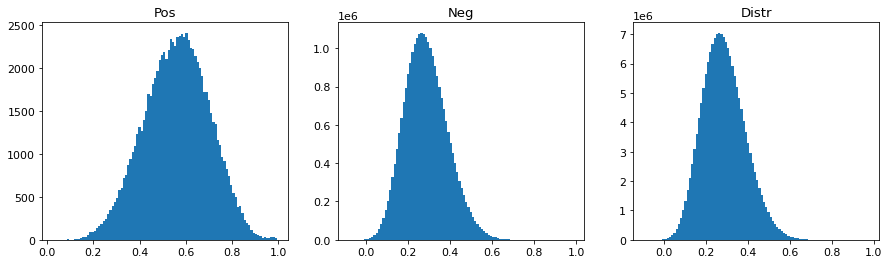

In [ ]:
to_plot = (cosine_query_pos, cosine_query_neg, cosine_query_distractors)
plot_names = ("Pos", "Neg", "Distr")

f, ax = plt.subplots(1,3)
f.set_size_inches(15,4)
# f.subplots_adjust(hspace=0.1, wspace=0.1)

for i in range(ax.size):
    current_ax = np.ravel(ax)[i] 
    current_ax.hist(to_plot[i], bins=100)
    current_ax.set_title(plot_names[i])

plt.show()

> As we can see - the model is not thoroughly hopeless

Check you code of functions which compute similarities:

In [ ]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names, 
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings, 
                                                            test_distractors_embeddings)

In [ ]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

Implement the final function: identification rate calculation

In [ ]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
    compute identification rate using precomputed cosine similarities between pairs
    at given fpr
    params:
      cosine_query_pos: cosine similarities between positive pairs from query
      cosine_query_neg: cosine similarities between negative pairs from query
      cosine_query_distractors: cosine similarities between negative pairs 
                                from query and distractors
      fpr: false positive rate at which to compute TPR
    output: 
      float: threshold for given fpr 
      float: TPR at given FPR
    '''
    num_false_pairs = len(cosine_query_neg) + len(cosine_query_distractors)
    N = int(num_false_pairs * fpr)

    false_pairs = np.sort(np.concatenate(
        (cosine_query_neg, cosine_query_distractors)))[::-1]
    threshold_similarity = false_pairs[N]
    tp = sum(e >= threshold_similarity for e in cosine_query_pos)
    tpr = tp / len(cosine_query_pos)

    return threshold_similarity, tpr

Check yourself:

In [ ]:
thr = []
tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                      test_cosine_query_distractors, fpr=fpr)
    thr.append(x)
    tpr.append(y)

In [ ]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(tpr), np.array(true_tpr)), "A mistake in computing tpr"

Finally compute tpr for faces query and distractors dataset and fpr = [0.5, 0.2, 0.1, 0.05]:

In [ ]:
thr_face = []
tpr_face = []
for fpr in [0.5, 0.2, 0.1, 0.05]:
    x, y = compute_ir(cosine_query_pos, cosine_query_neg, 
                    cosine_query_distractors, fpr=fpr)
    thr_face.append(x)
    tpr_face.append(y)

C:\Users\pqlet\AppData\Local\Temp\ipykernel_2220\4085425047.py:17: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


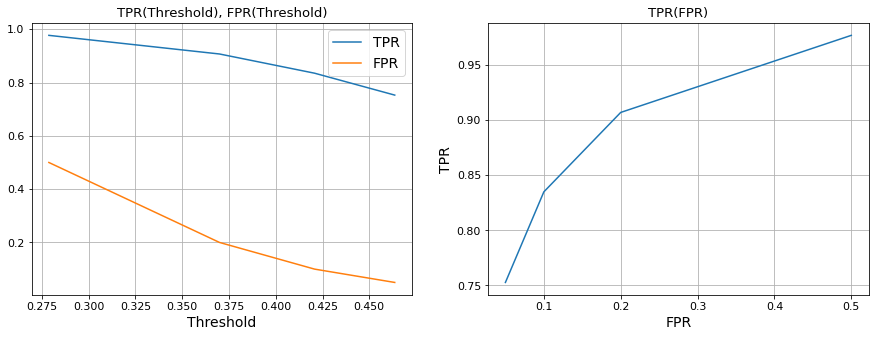

In [ ]:
fprs = [0.5, 0.2, 0.1, 0.05]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(thr_face,tpr_face, label="TPR")
ax1.plot(thr_face,fprs, label="FPR")
ax1.set_title("TPR(Threshold), FPR(Threshold)")
ax1.legend(fontsize=14)
ax1.grid()
ax1.set_xlabel("Threshold", fontsize=14)


ax2.plot(fprs, tpr_face)
ax2.set_title("TPR(FPR)")
ax2.set_ylabel("TPR", fontsize=14)
ax2.set_xlabel("FPR", fontsize=14)
ax2.grid()

plt.show()

# Task 3 (50% points): Loss functions

Building a network on task 1 we used an ordinary CE loss. But there are many more variants of loss functions that can be used to train neural network. We will discuss two of them, which are the most popular. More examples of losses for face recognition and their performance reviews you can find in this paper: https://arxiv.org/pdf/1901.05903.pdf

### TripletLoss (25% points)

This is another kind of loss which does not require a model to have last classification layer — it works directly with embeddings. It requires by design to make embeddings of one person be close on embeddings space and embeddings of different people be far away from each other. 

This loss has an advantage over CE-like losses: it does not rely on number of classes in dataset. If we have new faces of new people in a dataset, we won't need to completely retrain the network, we could just fine-tune the trained network on new photos.


**How TripletLoss works**:

Here the architecture of neural network will be slightly different than it was when we used CE loss: it won't have the last classification layer. The last layer of NN will output embeddings of the given photo. 

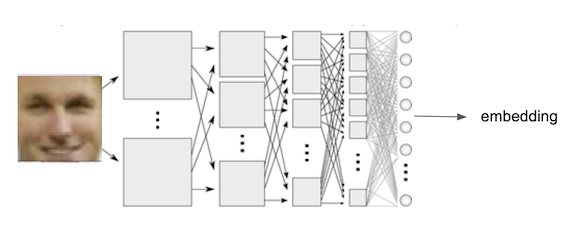

The TripletLoss function works directly with these embeddings. The idea of it is to make embeddings of the same people more close, compact in the embedding space, and the embeddings of the different people be more separate. There's a formula for the loss:

$$L(e, p, n) = max\{d(a, p) - d(a, n) + margin, 0\},$$

where 
- $e$ is embedding of a photo (output of a model)
- $p$ is a positive embedding for the photo (embedding that we want $e$ be close to)
- $n$ is a negative embedding for the photo (embedding that we want $e$ be far from)
- $d(x, y)$ is a distance measure between embeddings 
- margin — a positive margin to further boost the difference between $d(a, p)$ and $d(a, n)$

**All the embeddings $e$, $p$ and $n$ must be normalized before passing them to the loss**.

In our case for the given photo $E$ and it's embedding $e$ positive embedding $p$ must be an embedding of the photo of the same person and embedding $n$ must be an ambedding of the photo of the different person.

This emplementation of TripletLoss for PyTorch can be found [here](https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss). There are different variants of TripletLoss which can also boost performance and which you can implement by yourself, if you want:
- use more that 1 sample of $p$ and $n$ for one embedding $e$ 
- use special kinds of negatives: e.g. the negatives that are the most close to e (to boost them be further away from e)


**More to read about TripletLoss**:

The idea of TripletLoss: https://en.wikipedia.org/wiki/Triplet_loss

PyTorch implementation of TripletLoss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginWithDistanceLoss.html#torch.nn.TripletMarginWithDistanceLoss

**Task**: implement a model and train it with TripletLoss. Play with margin parameter to achieve better results.

Which loss among which you have tried is the best?

As we don't have a classification layer in our network, we need a custom procedure for accuracy calculation. You can use one of the following procedures:
- calculate accuracy on val and test sets using KNN with embeddings from training set as training points. (easy way)
- compute mean embeddings for every class from training set and use them as reference embeddings. Then for every embedding v from val and test sets calculate cosine similarities between v and mean embeddings from train set. (the more "right" way, but requires code writing)

You can use any of those two variants.

**Hints**:
- think of what the distance function $d$ should be in our case: training a model we want it to output embeddings which can be compared using cosine similarity function. Pay attention to that cosine similarity is not a distance measure — the more cosine distance, the closer embeddings are. Think how you can put cosine distance into TripletLoss function.
- to train model using this loss you'll need to rewrite the Dataset class so it gives you not the random image and its label, but the image, positive images and negative images for this image;
- don't forget to normalize embeddings for the loss! You may even do that by adding batchnorm/layernorm to the last layer of your network

#### Dataset for triplet loss

In [ ]:
class celebADataset_mine_forTriplet(Dataset):
    def __init__(self, dataset_type, targets_df, transform,
                 augm_even_mode=False, create_n_duplicates=0, aug=None,
                 classes_to_use=None):
        self.transforms = transform
        self.aug = aug
        self.is_train = dataset_type == "train"
        dataset_df = copy.deepcopy(targets_df)

        # Filtering only n=classes_to_use classes that have max number of photos
        if classes_to_use is not None:
            dataset_df = dataset_df.loc[dataset_df.target.isin(classes_to_use)]

        # Getting only needed part of df split
        img_paths_split, _ = get_paths(dataset_type)
        target_ids_split = list(
            map(lambda x: x.split("/")[-1], img_paths_split))
        dataset_df = dataset_df.loc[(
            dataset_df['image_id'].isin(target_ids_split))]
        dataset_df = dataset_df.reset_index(drop=True)

        if (augm_even_mode != False) or (create_n_duplicates > 0):
            dataset_df = augmentDf(
                targets_df=dataset_df, n_augm=create_n_duplicates, even_mode=augm_even_mode)

        self.dataset_df = dataset_df

    def __len__(self):
        return (self.dataset_df.shape[0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        anchor_img_name, anchor_label = self.dataset_df.loc[idx]

        anchor_img = io.imread(self.func_join_path_img(anchor_img_name))

        if self.is_train:
            positive_idxs_list = self.dataset_df[(self.dataset_df["image_id"] != anchor_img_name) &
                                                 (self.dataset_df.target == anchor_label)].index
            positive_idx = np.random.choice(positive_idxs_list)
            positive_img = io.imread(self.func_join_path_img(
                self.dataset_df.loc[positive_idx, "image_id"]))

            negative_idxs_list = self.dataset_df[(self.dataset_df["image_id"] != anchor_img_name) &
                                                 (self.dataset_df.target != anchor_label)].index
            negative_idx = np.random.choice(negative_idxs_list)
            negative_img = io.imread(self.func_join_path_img(
                self.dataset_df.loc[negative_idx, "image_id"]))

            if self.aug is not None:
                anchor_img = self.aug(image=anchor_img)['image']
                positive_img = self.aug(image=positive_img)['image']
                negative_img = self.aug(image=negative_img)['image']

            if self.transforms is not None:
                anchor_img = self.transforms(anchor_img)
                positive_img = self.transforms(positive_img)
                negative_img = self.transforms(negative_img)

            return anchor_img, positive_img, negative_img, anchor_label

        else:
            if self.transforms is not None:
                anchor_img = self.transforms(anchor_img)

            return anchor_img, anchor_label

    def func_join_path_img(self, img_name):
        return os.path.join(IMAGE_FOLDER, img_name)

In [ ]:
BATCH_SIZE=2
train_data_triplet = celebADataset_mine_forTriplet("train", target_df, common_transforms,
           #                                      augm_even_mode=True, create_n_duplicates=10, aug=augment_transform,
                                                   classes_to_use=classes_to_use
                                                   )
val_data_triplet = celebADataset_mine_forTriplet("val", target_df, common_transforms,
                                                 classes_to_use=classes_to_use)

train_loader_triplet = torch.utils.data.DataLoader(train_data_triplet, batch_size=BATCH_SIZE, shuffle=True,
                                                   pin_memory=True, num_workers=0, drop_last=True)
val_loader_triplet = torch.utils.data.DataLoader(val_data_triplet, batch_size=BATCH_SIZE, shuffle=False,
                                                 pin_memory=True, num_workers=0, drop_last=True)

####  Train function for Triplet loss

In [ ]:
from tqdm.autonotebook import tqdm, trange
import time
from sklearn.neighbors import KNeighborsClassifier


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']


def train_with_triplet_loss(model, optimizer, loss_fn, n_epochs,
                            train_loader, valid_loader,
                            number_of_triplets_for_loss=10,
                            knn_neighbours=5, scheduler=None):
    def distance_f(x, y): return 1.0 - F.cosine_similarity(x, y)
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0

    losses = {'train': []}
    metrics = {'train': [], "val": []}
    pbar = trange(n_epochs, desc="Epoch:")
    knn_epoch = KNeighborsClassifier(n_neighbors=knn_neighbours)

    for epoch in pbar:

        #######################
        ####### Training ######
        #######################
        model.train()
        train_losses_epoch = []
        a_embs_epoch_train = []
        a_embs_epoch_val = []
        a_targets_epoch_train = []

        for x_a, x_p, x_n, y_real in tqdm(train_loader, leave=False, desc=f"{epoch} iter:"):
            x_a = x_a.to(device)
            x_p = x_p.to(device)
            x_n = x_n.to(device)
            optimizer.zero_grad()
            loss = torch.tensor([0.0]).to(device)
            # Instead of hard negative mining 
            # Accrue gradients over many trplets
            for _ in range(number_of_triplets_for_loss):
                a_emb = model(x_a)
                p_emb = model(x_p)
                n_emb = model(x_n)
                loss += loss_fn(a_emb, p_emb, n_emb)
            del x_a
            del x_p
            del x_n
            loss.backward()
            optimizer.step()

            a_embs_epoch_train.append(a_emb.detach().cpu().numpy())
            a_targets_epoch_train.append(y_real)
            train_losses_epoch.append(loss.item())

        # computing training embeddings for KNN
        # to predict target for accuracy evaluation
        a_embs_epoch_train, a_targets_epoch_train = np.concatenate(
            a_embs_epoch_train), np.concatenate(a_targets_epoch_train)
        knn_epoch.fit(a_embs_epoch_train, a_targets_epoch_train)
        y_pred_train = knn_epoch.predict(a_embs_epoch_train)
        train_metric_epoch = accuracy_score(
            a_targets_epoch_train, y_pred_train)

        losses['train'].append(np.mean(train_losses_epoch))
        metrics['train'].append(train_metric_epoch)
        ########################
        ####### Validation #####
        ########################
        model.eval()
        with torch.no_grad():
            for x_batch, y_real in valid_loader:
                a_emb = model(x_batch.to(device))
                a_embs_epoch_val.append(a_emb.detach().cpu().numpy())
                # YOU CAN NOT append y_real here just take valid_loader.dataset.targets, for the shuffle=False

        a_embs_epoch_val = np.concatenate(a_embs_epoch_val)
        y_pred_val = knn_epoch.predict(a_embs_epoch_val)
        val_metric_epoch = accuracy_score(valid_loader.dataset.dataset_df.target.values,
                                          y_pred_val)
        metrics['val'].append(val_metric_epoch)

        if val_metric_epoch > best_acc:
            best_acc = val_metric_epoch
            best_model_wts = model.state_dict()

        # --------------------- CLEARING OUTPUT ---------------------
        clear_output()

        #########################
        # Scheduler making step #
        #########################
        if scheduler is not None:
            print("stepping with scheduler")
            scheduler.step()
            print("Learning rate", get_lr(optimizer), scheduler.get_lr())

        pbar.set_description(f"Epoch: {(epoch+1)}/{(n_epochs)} \
                         TrainLoss: {losses['train'][-1]:.4f} \
                         TrainAcc: {train_metric_epoch:.4f} \
                         ValAcc: {val_metric_epoch:.4f}")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        # График лоса на обучении на каждой эпохе
        ax1.plot(losses['train'], color='orange', label='train')
        ax1.set_title(f"Loss (best train={round(np.min(losses['train']),6)})")
        ax1.legend(prop={"size": 12})

        ax2.plot(metrics['train'], color='orange', label='train')
        ax2.plot(metrics['val'], color='dodgerblue', label='val')
        ax2.set_title(f"Accuracy (best val={round(np.max(metrics['val']),6)})")
        ax2.legend(prop={"size": 12})

        plt.show()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

### ArcFace Loss (Additive Angular Margin Loss) (25% points)

This loss is somewhat "SOTA" for face recognition systems (somewhat — because actually different variants of losses and their combinations may be the best for different network architectures). This loss inherits idea from CE loss but further develops it to achieve better embeddings distribution on a sphere. It introduces some geodesic constraints to enhance intra-class compactness and inter-class discrepancy.



**How ArcFace loss works**:

This loss is a variation of a standard SoftMax CE loss, which enforces embeddings of different classes (people) be further away: have a more sparse representation of embeddings in embedding space, enforce more evident gap between the nearest classes.

The standard SoftMax CE loss for classification task is presented as follows:

$$L_{CE} = \frac{-1}{N}\sum_1^N \frac{e^{W_{y_i}^{T}x_i + b_{y_i}}}{\sum^n_{j=1}e^{W_j^Tx_i+b_j}},$$

where:
- $x_i \in \mathbb{R^d}$ denotes the deep feature of the $i$-th sample, belonging to the $y_i$-th class;
- $W_j \in \mathbb{R^d}$ denotes the j-th column of the weight;
- $W \in \mathbb{R^d}$ and $b_j \in \mathbb{R^d}$ is the bias term;
- $N$ — batch size;
- $n$ — class number.

It appears, that, though this loss works well, it does not explicitly optimise the feature embedding to enforce higher similarity for intra- class samples and diversity for inter-class samples, which results in a performance gap for deep face recognition under large intra-class appearance variations.

Let's do some work on this loss formula:
- fix the bias $b_j=0$;
- normalize weight ||$W_j$|| = 1;
- normalize embedding ||$x_i$|| = 1 and re-scale it to s (s is a hyperparameter)

The normalisation step on embeddings and weights makes the predictions only depend on the angle between the embedding and the weight. The learned embeddings fare thus distributed on a hypersphere with a radius of s.

So we get the following loss function now:

$$L = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos\Theta_{y_i}}}{e^{s\ cos\Theta_{y_i}} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

Final step: let's add an additive angular margin penalty $m$ between $x_i$ and $W_{y_i}$ to simultaneously enhance the intra-class compactness and inter-class discrepancy:

$$L_{ArcFace} = \frac{-1}{N}\sum_1^N \frac{e^{s\ cos(\Theta_{y_i} + m)}}{e^{s\ cos(\Theta_{y_i} + m)} + \sum^n_{j=1,\ j\ne y_i} e^{s\ cos\Theta_j}}$$

SO this is an ArcFace loss. It has 2 hyperparameters: s and m.

The original paper to read about ArcFace more precisely: https://arxiv.org/pdf/1801.07698.pdf

The original repo, where you can find a code sample: https://github.com/deepinsight/insightface

**Task**: implement a model and train it with ArcFace loss. Play with ArcFace loss parameters and see if you can beat a model with CE loss.

In [ ]:
import math

class ArcModule(nn.Module):
    def __init__(self, in_features, out_features, s = 64, m = 0.5):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.s = s
        self.m = m
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        nn.init.xavier_normal_(self.weight)

        self.cos_m = math.cos(m)
        self.sin_m = math.sin(m)
        self.th = torch.tensor(math.cos(math.pi - m))
        self.mm = torch.tensor(math.sin(math.pi - m) * m)

    def forward(self, inputs, labels):
        cos_th = F.linear(inputs, F.normalize(self.weight))
        cos_th = cos_th.clamp(-1, 1) 
        sin_th = torch.sqrt(1.0 - torch.pow(cos_th, 2))
        cos_th_m = cos_th * self.cos_m - sin_th * self.sin_m
        cos_th_m = torch.where(cos_th > self.th, cos_th_m, cos_th - self.mm)

        cond_v = cos_th - self.th
        cond = cond_v <= 0
        cos_th_m[cond] = (cos_th - self.mm)[cond]

        if labels.dim() == 1:
            labels = labels.unsqueeze(-1)
        onehot = torch.zeros(cos_th.size()).to(device)
        labels = labels.type(torch.LongTensor).to(device)
        onehot.scatter_(1, labels, 1.0)
        outputs = onehot * cos_th_m + (1.0 - onehot) * cos_th
        outputs = outputs * self.s
        return outputs

In [ ]:
class DenseNet_Arc(nn.Module):

    def __init__(self, channel_size, out_feature, scale_arc, margin_arc, dropout=0.4, backbone='resnet50d', pretrained=True):
        super(DenseNet_Arc, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        # DenseNet
        self.in_features = self.backbone.classifier.in_features
        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace=True)

        # For 112 - 9216
#         self.fc1 = nn.Linear(9216, self.channel_size)
        # For 128 16384 
        # self.fc1 = nn.Linear(16384, self.channel_size)
        # For 224 50176
#         self.fc1 = nn.Linear(50176, self.channel_size)
        # For 64 - 4096
        self.fc1 = nn.Linear(4096, self.channel_size)


        self.bn2 = nn.BatchNorm1d(self.channel_size)
        self.margin = ArcModule(in_features=self.channel_size, out_features = self.out_feature, s=scale_arc, m=margin_arc)
        
    def forward(self, x, labels=None):
        # DenseNet
        features = self.backbone.features(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        if labels is not None:
            return self.margin(features, labels)
        # print(features)
        print("RETURN FEATURES")
        return features

In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

BATCH_SIZE = 300
N_CLASSES_TO_USE = 50

CROP_SIZE = [90, 80]
RESIZE_SIZE = [64,64]

STATS_FOR_NORM = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

EVEN_AUGM_TRAIN = True
N_DUPLICATES_TRAIN = 5
COMMON_P_AUG = 0.3

train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE, resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, n_duplicates_train=N_DUPLICATES_TRAIN, common_p_aug=COMMON_P_AUG
)

###### Mode initialization ######
model_arc = DenseNet_Arc(100, N_CLASSES_TO_USE, scale_arc=1, margin_arc=0.1).to(device)

model_arc.requires_grad_(requires_grad=True);
###### Training Set up ######

LR = 3e-3
N_EPOCHS = 15
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
    # label_smoothing=0.1, 
)
optim = torch.optim.AdamW(model_arc.parameters(), lr = LR, 
                          weight_decay=1e-6
                          )
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[7], gamma=0.1)

model_arc = train(
    mode='arc',
    model=model_arc, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)

# ResNet50d arc

In [ ]:
class ReseNet_Arc(nn.Module):

    def __init__(self, channel_size, out_feature, scale_arc, margin_arc, dropout=0.4, backbone='resnet50d', pretrained=True):
        super(ReseNet_Arc, self).__init__()
        self.backbone = timm.create_model(backbone, pretrained=pretrained)
        self.channel_size = channel_size
        self.out_feature = out_feature
        # ResNet - fc
        self.in_features = self.backbone.fc.in_features
        self.backbone = nn.Sequential(*list(model_ce.children())[:-2])


        self.bn1 = nn.BatchNorm2d(self.in_features)
        self.dropout = nn.Dropout2d(dropout, inplace=True)

        # For 112 - 9216
#         self.fc1 = nn.Linear(9216, self.channel_size)
        # For 128 16384 
        # self.fc1 = nn.Linear(16384, self.channel_size)
        # For 224 50176
#         self.fc1 = nn.Linear(50176, self.channel_size)
        # For 64 - 8192
        self.fc1 = nn.Linear(8192, self.channel_size)


        self.bn2 = nn.BatchNorm1d(self.channel_size)
        self.margin = ArcModule(in_features=self.channel_size, out_features = self.out_feature, s=scale_arc, m=margin_arc)
        
    def forward(self, x, labels=None):
        features = self.backbone(x)
        features = self.bn1(features)
        features = self.dropout(features)
        features = features.view(features.size(0), -1)
        features = self.fc1(features)
        features = self.bn2(features)
        features = F.normalize(features)
        if labels is not None:
            return self.margin(features, labels)
        print("RETURN FEATURES")
        return features

### Check with CE 

Epoch 5/5
Train Loss = 1.5298557792391096
Validation Loss = 2.1169017553329468
Learning rate 0.003


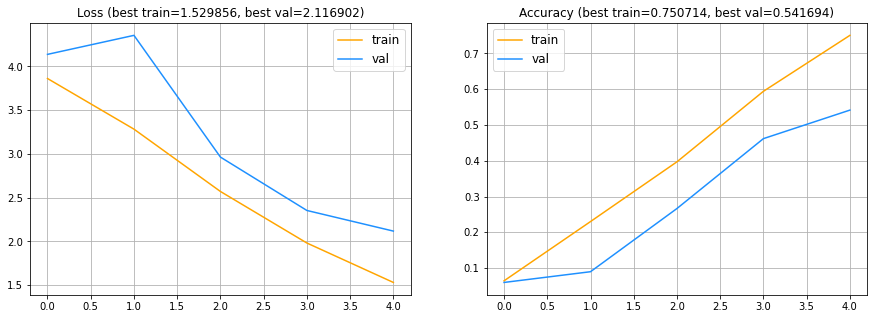

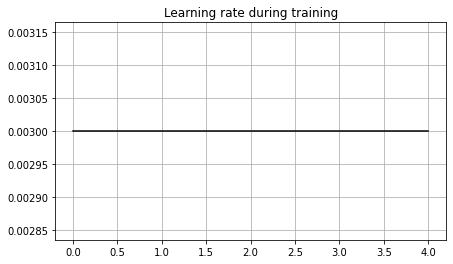

Training complete in 0m 45s
Best val Acc: 0.541694


In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

# Data Params
BATCH_SIZE = 200
N_CLASSES_TO_USE = 50
CROP_SIZE = (90, 80)
RESIZE_SIZE = (64, 64)
STATS_FOR_NORM = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
EVEN_AUGM_TRAIN = True
N_DUPLICATES_TRAIN = 5
COMMON_P_AUG = 0.3
train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE,
    resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG
)

# Model
model_ce = timm.create_model('resnet50d', pretrained=True, num_classes=N_CLASSES_TO_USE)
# model_ce.classifier = nn.Linear(model_ce.classifier.in_features, N_CLASSES_TO_USE)

# EfficientNetv2S
# model_ce = torchvision.models.efficientnet_v2_s(weights=torchvision.models.EfficientNet_V2_S_Weights.DEFAULT)
# model_ce.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)

model_ce.to(device)
model_ce.requires_grad = True

# Learning Params
LR = 3e-3
N_EPOCHS = 5
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
    label_smoothing=0.1, 
)
optim = torch.optim.AdamW(model_ce.parameters(), lr = LR, weight_decay=1e-6)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[15], gamma=0.1)
model_ce = train(
    mode='ce',
    model=model_ce, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)

### Arc

Epoch 20/20
Train Loss = 0.42478744983673095
Validation Loss = 1.9119012355804443
Learning rate 0.00030000000000000003


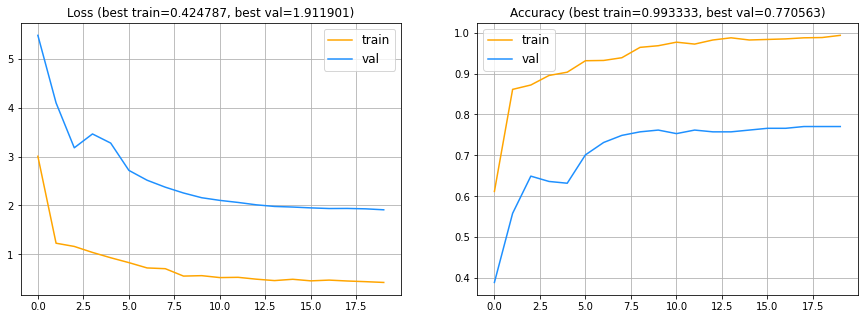

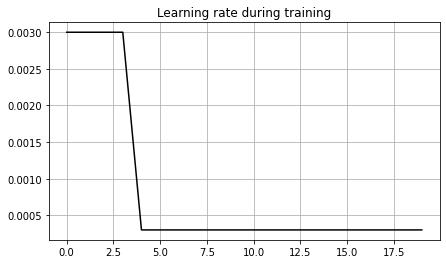

Training complete in 3m 23s
Best val Acc: 0.770563


In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

BATCH_SIZE = 300
N_CLASSES_TO_USE = 50

CROP_SIZE = [90, 80]
RESIZE_SIZE = [64,64]

STATS_FOR_NORM = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

EVEN_AUGM_TRAIN = True
N_DUPLICATES_TRAIN = 5
COMMON_P_AUG = 0.3

train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE, resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, n_duplicates_train=N_DUPLICATES_TRAIN, common_p_aug=COMMON_P_AUG
)

###### Mode initialization ######
model_arc = ReseNet_Arc(50, N_CLASSES_TO_USE, scale_arc=10, margin_arc=0.5).to(device)

model_arc.requires_grad_(requires_grad=True);
###### Training Set up ######

LR = 3e-3
N_EPOCHS = 20
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
    label_smoothing=0.05, 
)
optim = torch.optim.AdamW(model_arc.parameters(), lr = LR, 
                          weight_decay=1e-7
                          )
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5], gamma=0.1)

model_arc = train(
    mode='arc',
    model=model_arc, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
inference_model(model_arc, val_loader_mine, mode='arc'), inference_model(model_arc, test_loader_mine, mode='arc'), 

In [ ]:
# model_arc(next(iter(train_loader_mine))[0].cuda(), next(iter(train_loader_mine))[1].cuda())

tensor([[nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        ...,
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan],
        [nan, nan, nan,  ..., nan, nan, nan]], device='cuda:0',
       grad_fn=<MulBackward0>)

Epoch 5/5
Train Loss = nan
Validation Loss = nan
Learning rate 0.00030000000000000003


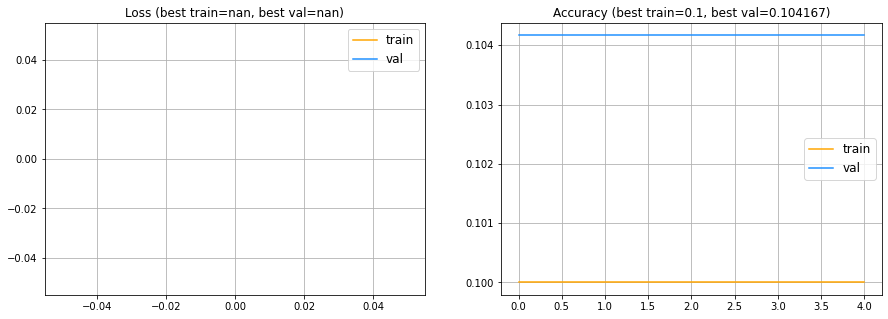

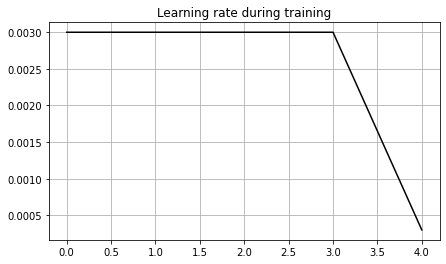

Training complete in 0m 12s
Best val Acc: 0.104167


(0.10416666666666667, 0.08888888888888889)

In [ ]:
tqdm = partial(tqdm, position=0, leave=True)

BATCH_SIZE = 300
N_CLASSES_TO_USE = 10

CROP_SIZE = [90, 80]
RESIZE_SIZE = [64,64]

STATS_FOR_NORM = [[0.5, 0.5, 0.5], [0.5, 0.5, 0.5]]

EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 0
COMMON_P_AUG = 0

train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, n_classes_to_use=N_CLASSES_TO_USE,
    crop_size=CROP_SIZE, resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, n_duplicates_train=N_DUPLICATES_TRAIN, common_p_aug=COMMON_P_AUG
)

###### Mode initialization ######
model_arc = ReseNet_Arc(100, N_CLASSES_TO_USE, scale_arc=1, margin_arc=0.01).to(device)

model_arc.requires_grad_(requires_grad=True);
###### Training Set up ######

LR = 3e-3
N_EPOCHS = 5
loss_1 = nn.CrossEntropyLoss(
    reduction="mean", 
    # label_smoothing=0.05, 
)
optim = torch.optim.AdamW(model_arc.parameters(), lr = LR, 
                          weight_decay=1e-7
                          )
scheduler = torch.optim.lr_scheduler.MultiStepLR(optim, milestones=[5], gamma=0.1)

model_arc = train(
    mode='arc',
    model=model_arc, 
    optimizer=optim, 
    loss_fn=loss_1, 
    n_epochs=N_EPOCHS, 
    train_loader=train_loader_mine, 
    valid_loader=val_loader_mine,
    scheduler=scheduler
)
inference_model(model_arc, val_loader_mine, mode='arc'), inference_model(model_arc, test_loader_mine, mode='arc'), 

In [ ]:
embs = []
model_arc.eval()
with torch.no_grad():
    for x, _ in val_loader_mine:
        res = (model_arc(x.to(device)).cpu())
        print(res)
        embs.append(res)

embs = np.concatenate(embs)

RETURN FEATURES
torch.Size([48, 10])
tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
   

In [ ]:
len(val_loader_mine.dataset)

48

In [ ]:
embs.shape

(48, 10)

In [ ]:
plt.scatter(embs)

TypeError: ignored

# Full Pipeline for Face Recognition

> The pipeline below uses model trained with CE to classify test split from 1k dataset using images from In-The-Wild dataset

It also utilizes YoloV5 finetuned with In-The-Wild dataset bboxes as detection model and custom model for alignment with ResNet18 backbone as landmark detection model trained in the neighbour notebook


In [ ]:
from GitHub_release.utils import *

C:\Users\pqlet\my_virtualenvs\cuda_pytorch_113\lib\site-packages\albumentations\augmentations\dropout\cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
C:\Users\pqlet\AppData\Local\Temp\ipykernel_2220\3964082126.py:46: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  train_data = celebADataset_mine('train', target_df, common_transforms,
C:\Users\pqlet\AppData\Local\Temp\ipykernel_2220\3964082126.py:52: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  val_data = celebADataset_mine('val', target_df, common_transforms,
C:\Users\pqlet\AppData\Local\Temp\ipykernel_2220\3964082126.py:56: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  test_data = celebADataset_mine('test', t

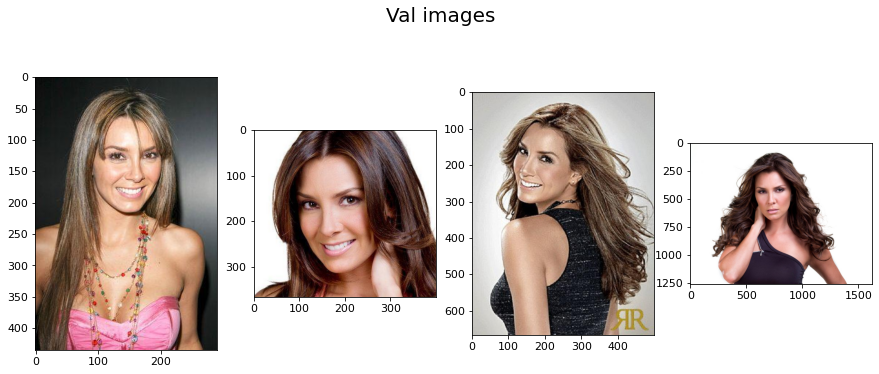

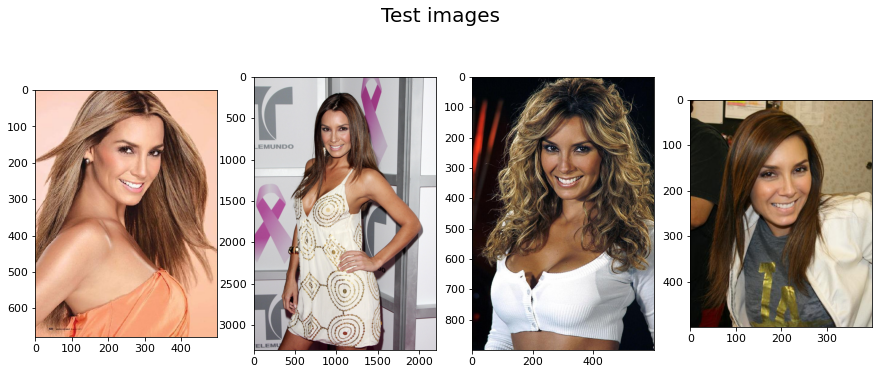

In [ ]:
BATCH_SIZE = 1
N_CLASSES_TO_USE = 500

EVEN_AUGM_TRAIN = False
N_DUPLICATES_TRAIN = 0
COMMON_P_AUG = 0

train_loader_mine, val_loader_mine, test_loader_mine = get_3_dataloaders(
    batch_size=BATCH_SIZE, 
    n_classes_to_use=N_CLASSES_TO_USE,
#     crop_size=CROP_SIZE,
#     resize_size=RESIZE_SIZE, 
#     stats_for_norm=STATS_FOR_NORM,
    even_augm_train=EVEN_AUGM_TRAIN, 
    n_duplicates_train=N_DUPLICATES_TRAIN, 
    common_p_aug=COMMON_P_AUG,
    is_wild_dataset=True
)

f, ax = plt.subplots(1,4)
f.set_size_inches(15,6)
for i, (image, _) in enumerate(val_loader_mine):
    if i == ax.size: break
    current_ax = np.ravel(ax)[i] 
    current_ax.imshow(image[0].permute(1,2,0))
f.suptitle("Val images",fontsize=20)
plt.show()

f, ax = plt.subplots(1,4)
f.set_size_inches(15,6)
for i, (image, _) in enumerate(test_loader_mine):
    if i == ax.size: break
    current_ax = np.ravel(ax)[i] 
    current_ax.imshow(image[0].permute(1,2,0))
f.suptitle("Test images", fontsize=20)
plt.show()

In [ ]:
detal = DetectorAligner(
    yolov5_weights_path='GitHub_release/trained_models/Yolov5_model_weights.pt',
    alignment_model_path='GitHub_release/trained_models/Alignment_model_statedict.pth',
)

Using cache found in C:\Users\pqlet/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5 🚀 2022-8-11 Python-3.9.13 torch-1.12.0+cu113 CUDA:0 (NVIDIA GeForce GTX 1650 Ti, 4096MiB)

Fusing layers... 
YOLOv5n summary: 213 layers, 1760518 parameters, 0 gradients
Adding AutoShape... 


In [ ]:
model_pipe = torchvision.models.efficientnet_v2_s()
model_pipe.classifier[1] = nn.Linear(model_ce.classifier[1].in_features, N_CLASSES_TO_USE)
# model_pipe.load_state_dict(torch.load("saved_models/Eff_net_500classes.pth"))
model_pipe.load_state_dict(torch.load("trained/Eff_net_500classes.pth"))
model_pipe.eval();

In [ ]:
preds_test = []

# Iterating over image paths
for image_path, label in tqdm(zip(test_loader_mine.dataset.img_paths, test_loader_mine.dataset.targets), 
                              total=len(test_loader_mine.dataset)):
    cropal = detal.get_face_img(image_path)
    if cropal is None:
        pred = -1
    else:
        pred = model_pipe(cropal[None,:]).argmax(dim=1).item()
    preds_test.append(pred)

  0%|          | 0/1975 [00:00<?, ?it/s]

Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn't detect any faces
Model didn

In [ ]:
accuracy_score(test_loader_mine.dataset.targets, q)

0.4521518987341772

> Accuracy drops heavily due to custom detection and alignment but it works